<a href="https://colab.research.google.com/github/BLayus/Acadia-Churn-Case/blob/main/Notebook/Case_Bix_Machine_failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Libraries

In [1]:
! pip install scikit-optimize

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import datetime as dt
import warnings
import time
warnings.filterwarnings("ignore")

# Data viz

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ML Libraries

from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

from sklearn.impute import SimpleImputer

from sklearn.model_selection import (train_test_split, KFold, cross_val_score,
                                    RandomizedSearchCV, StratifiedKFold)

from sklearn.metrics import (roc_curve, auc, roc_auc_score, confusion_matrix, log_loss,
                             precision_score, accuracy_score, recall_score, f1_score, classification_report,
                             make_scorer, precision_recall_curve, precision_recall_fscore_support)

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from skopt import BayesSearchCV

from yellowbrick.model_selection import RFECV


In [3]:
# Apply a plot style to the charts

#plt.style.use('seaborn-v0_8')

sns.set_style('darkgrid', {'grid.color': '.8',
                           'grid.linestyle': '-',
                           'text.color': '.2',
                           'xtick.color': 'dimgray',
                           'ytick.color': 'dimgray',
                           'axes.labelcolor': 'dimgray'})

# Defining color pallete
colors = ['#4c94de', 'grey', 'cornflowerblue', 'silver', 'lightsteelblue', 'whitesmoke']
sns.set_palette(sns.color_palette(colors))

### Open Datasets

In [128]:
# import dataset

from google.colab import drive
drive.mount('/content/drive')

df_prev = pd.read_csv('/content/drive/MyDrive/Data Science/Case Bix Tecnologia/air_system_previous_years.csv')

df_curr = pd.read_csv('/content/drive/MyDrive/Data Science/Case Bix Tecnologia/air_system_present_year.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Open the datasets and look at the main info

df_prev.sample(5)

class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
29480   neg      18      0          10      8      0      0      0      0   
56472   neg   38300     na         588    550      0      0      0      0   
35454   neg   34812     na  2130706440    826      0      0      0      0   
58062   neg  122930     na        2624   2400      0      0      0      0   
39151   neg   30322     na         462    438      0      0      0      0   

      ag_002  ...  ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008  \
29480      0  ...     254      44      20      20      28      14       0   
56472      0  ...  295836  134706  252728  278584  194686  169626  282316   
35454      0  ...  168786   77196  159954  551904  474880   73896   21958   
58062      0  ...       0       0       0       0       0       0       0   
39151      0  ...  344190  177988  372706  218432  126324   70918   84450   

      ee_009 ef_000 eg_000  
29480      0      0      0  
56472  20252      0      0  
35454      0      0      0  
58062      0      0      0  
39151   1044      0      0  

[5 rows x 171 columns]

In [127]:
df_curr.sample(5)

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
638       0      10     NaN  2.400000e+01    22.0     0.0     0.0     0.0   
4297      0   41348     NaN  2.130706e+09   380.0     0.0     0.0     0.0   
1377      0       8     NaN  2.000000e+01    20.0     0.0     0.0     0.0   
8366      0    2164     NaN  4.200000e+01    38.0     0.0     0.0     0.0   
5329      0   50166     NaN  1.360000e+02   136.0     0.0     0.0     0.0   

      ag_001  ag_002  ...    ee_002    ee_003    ee_004    ee_005    ee_006  \
638      0.0     0.0  ...     100.0       6.0       2.0       0.0       0.0   
4297     0.0     0.0  ...  393396.0  207428.0  385346.0  374626.0  320748.0   
1377     0.0     0.0  ...      42.0      10.0      14.0      14.0      34.0   
8366     0.0     0.0  ...    4694.0    1556.0    8046.0   85204.0      10.0   
5329     0.0     0.0  ...  437642.0  215876.0  406868.0  284718.0  207248.0   

        ee_007    ee_008   ee_009  ef_000  eg_000  
638        0.0       0.0      0.0     0.0     0.0  
4297  166340.0   45896.0   2624.0     0.0     0.0  
1377      50.0       0.0      0.0     0.0     0.0  
8366       0.0       0.0      0.0     0.0     0.0  
5329  147356.0  434158.0  66862.0     0.0     0.0  

[5 rows x 171 columns]

In [7]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [8]:
df_curr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 20.9+ MB


In [9]:
# From the previous info about those two datasets, we can infer that there are large dimensionality (more than 170 columns) and several data points

# The previous years dataset has 60K entries and the current year has 16K

# The datatypes are all objects, except one that is presented as int64

### Data Cleaning and Preparing

In [10]:
# Begin checking for duplicates

def check_duplicates (df):
  duplicates = df.duplicated()

  print(duplicates.value_counts())

check_duplicates(df_prev)

# There are no duplicated data!


False    60000
Name: count, dtype: int64


In [11]:
# Replace all "nas" with np.nan

def replace_na (df, value, new_value):
  df.replace(value, new_value, inplace= True)

  return df


#df_prev.replace('na', np.nan, inplace=True)

#df_curr.replace('na', np.nan, inplace=True)


replace_na(df_prev, 'na', np.nan)

df_prev.sample(5)


class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
22009   neg      12      0          10      8      0      0      0      0   
46407   neg    1274    NaN           0    NaN      0      0      0      0   
23762   neg   60458    NaN        1476   1364      0      0      0      0   
24660   neg   83608    NaN  2130706432    522      0      0      0      0   
43832   neg    1014      2          38    NaN      0      0      0      0   

      ag_002  ...   ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008  \
22009      0  ...       52       6      26      24      54      74       0   
46407      0  ...     2434    1390    1592   49394     856       2       0   
23762      0  ...   600406  286616  499046  388238  313152  219166  382460   
24660      0  ...  1026158  509760  870552  504320  327874  195650  323174   
43832    310  ...     6128    3608    7180    7036    4730   15908      96   

      ee_009 ef_000 eg_000  
22009      0      0      0  
46407      0      0      0  
23762  16722      0      0  
24660  30456      0      0  
43832      0      0      0  

[5 rows x 171 columns]

In [12]:
# Encode column 'class' with numerical values 1 = pos, 0 = neg

def encode_class (df, column, class1, class2, code1, code2):
  df[column] = df[column].apply(lambda x: code1 if x == class1 else code2 if x == class2 else x)

  return df

encode_class (df_prev, 'class', 'neg', 'pos', 0, 1)


class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0          0   76698    NaN  2130706438    280      0      0      0      0   
1          0   33058    NaN           0    NaN      0      0      0      0   
2          0   41040    NaN         228    100      0      0      0      0   
3          0      12      0          70     66      0     10      0      0   
4          0   60874    NaN        1368    458      0      0      0      0   
...      ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995      0  153002    NaN         664    186      0      0      0      0   
59996      0    2286    NaN  2130706538    224      0      0      0      0   
59997      0     112      0  2130706432     18      0      0      0      0   
59998      0   80292    NaN  2130706432    494      0      0      0      0   
59999      0   40222    NaN         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  ee_007  ee_008  \
0          0  ...  1240520  493384   721044   469792   339156  157956   73224   
1          0  ...   421400  178064   293306   245416   133654   81140   97576   
2          0  ...   277378  159812   423992   409564   320746  158022   95128   
3          0  ...      240      46       58       44       10       0       0   
4          0  ...   622012  229790   405298   347188   286954  311560  433954   
...      ...  ...      ...     ...      ...      ...      ...     ...     ...   
59995      0  ...   998500  566884  1290398  1218244  1019768  717762  898642   
59996      0  ...    10578    6760    21126    68424      136       0       0   
59997      0  ...      792     386      452      144      146    2622       0   
59998      0  ...   699352  222654   347378   225724   194440  165070  802280   
59999      0  ...   440066  183200   344546   254068   225148  158304  170384   

       ee_009 ef_000 eg_000  
0           0      0      0  
1        1500      0      0  
2         514      0      0  
3           0      4     32  
4        1218      0      0  
...       ...    ...    ...  
59995   28588      0      0  
59996       0      0      0  
59997       0      0      0  
59998  388422      0      0  
59999     158      0      0  

[60000 rows x 171 columns]

In [134]:
# Set correct data types

# Select all columns except 'class'
cols_to_convert = df_prev.columns[df_prev.columns != 'class']

# Convert the selected columns to numeric
df_prev[cols_to_convert] = df_prev[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Select all columns except 'class'
cols_to_convert = df_curr.columns[df_curr.columns != 'class']

# Convert the selected columns to numeric
df_curr[cols_to_convert] = df_curr[cols_to_convert].apply(pd.to_numeric, errors='coerce')


In [14]:
# Show the transformed dtypes and samples of the datasets

display(df_prev.info())
df_prev.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(2)
memory usage: 78.3 MB


None

class  aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
17123      0     264     NaN   248.0   196.0     0.0     0.0     0.0     0.0   
36678      0   39720     NaN  8366.0  6338.0     0.0     0.0     0.0     0.0   
34892      0   10546     NaN   438.0     NaN     0.0     0.0     0.0     0.0   
50277      0     304     NaN    30.0     NaN     0.0     0.0     0.0     0.0   
25523      0     326     NaN     6.0     6.0     0.0     0.0     0.0     0.0   

       ag_002  ...    ee_002    ee_003    ee_004    ee_005    ee_006   ee_007  \
17123     0.0  ...    3816.0    1160.0    2196.0    3542.0       6.0      0.0   
36678     0.0  ...  439176.0  221998.0  388574.0  217526.0  148568.0  72762.0   
34892     0.0  ...   57568.0   52592.0  275710.0   58534.0   38070.0  20140.0   
50277     0.0  ...    3306.0    1222.0    1304.0    2044.0    1902.0   3008.0   
25523     0.0  ...    2936.0    2184.0    7424.0    2306.0     266.0     32.0   

        ee_008  ee_009  ef_000  eg_000  
17123      0.0     0.0     0.0     0.0  
36678  25846.0     0.0     0.0     0.0  
34892   6560.0    74.0     0.0     0.0  
50277      0.0     0.0     0.0     0.0  
25523      0.0     0.0     0.0     0.0  

[5 rows x 171 columns]

In [15]:
# Show the transformed dtypes and samples of the datasets

display(df_curr.info())
df_curr.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 20.9+ MB


None

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
10449   neg   39498     NaN  1.660000e+02   116.0     0.0     0.0     0.0   
7126    neg    1536     NaN  1.400000e+01    10.0     0.0     0.0     0.0   
2706    neg      90     0.0  2.130706e+09     8.0     0.0     0.0     0.0   
3577    neg     480     2.0  1.060000e+02     NaN     0.0     0.0     0.0   
11578   neg      38     0.0  2.130706e+09    46.0     0.0     0.0     0.0   

       ag_001  ag_002  ...    ee_002    ee_003    ee_004    ee_005    ee_006  \
10449     0.0     0.0  ...  420122.0  217696.0  411304.0  353354.0  189184.0   
7126      0.0     0.0  ...    3562.0    1550.0    4814.0    5168.0    6124.0   
2706      0.0     0.0  ...    1184.0     552.0     886.0     340.0     430.0   
3577      0.0     0.0  ...    3002.0     866.0    2168.0    2460.0    3280.0   
11578     0.0     0.0  ...     418.0     146.0     116.0      90.0     186.0   

        ee_007    ee_008  ee_009  ef_000  eg_000  
10449  90940.0  127462.0  5138.0     0.0     0.0  
7126   42056.0      56.0     0.0     0.0     0.0  
2706     540.0       0.0     0.0     0.0     0.0  
3577    8466.0      88.0     0.0     0.0     0.0  
11578    158.0       0.0     0.0     0.0     0.0  

[5 rows x 171 columns]

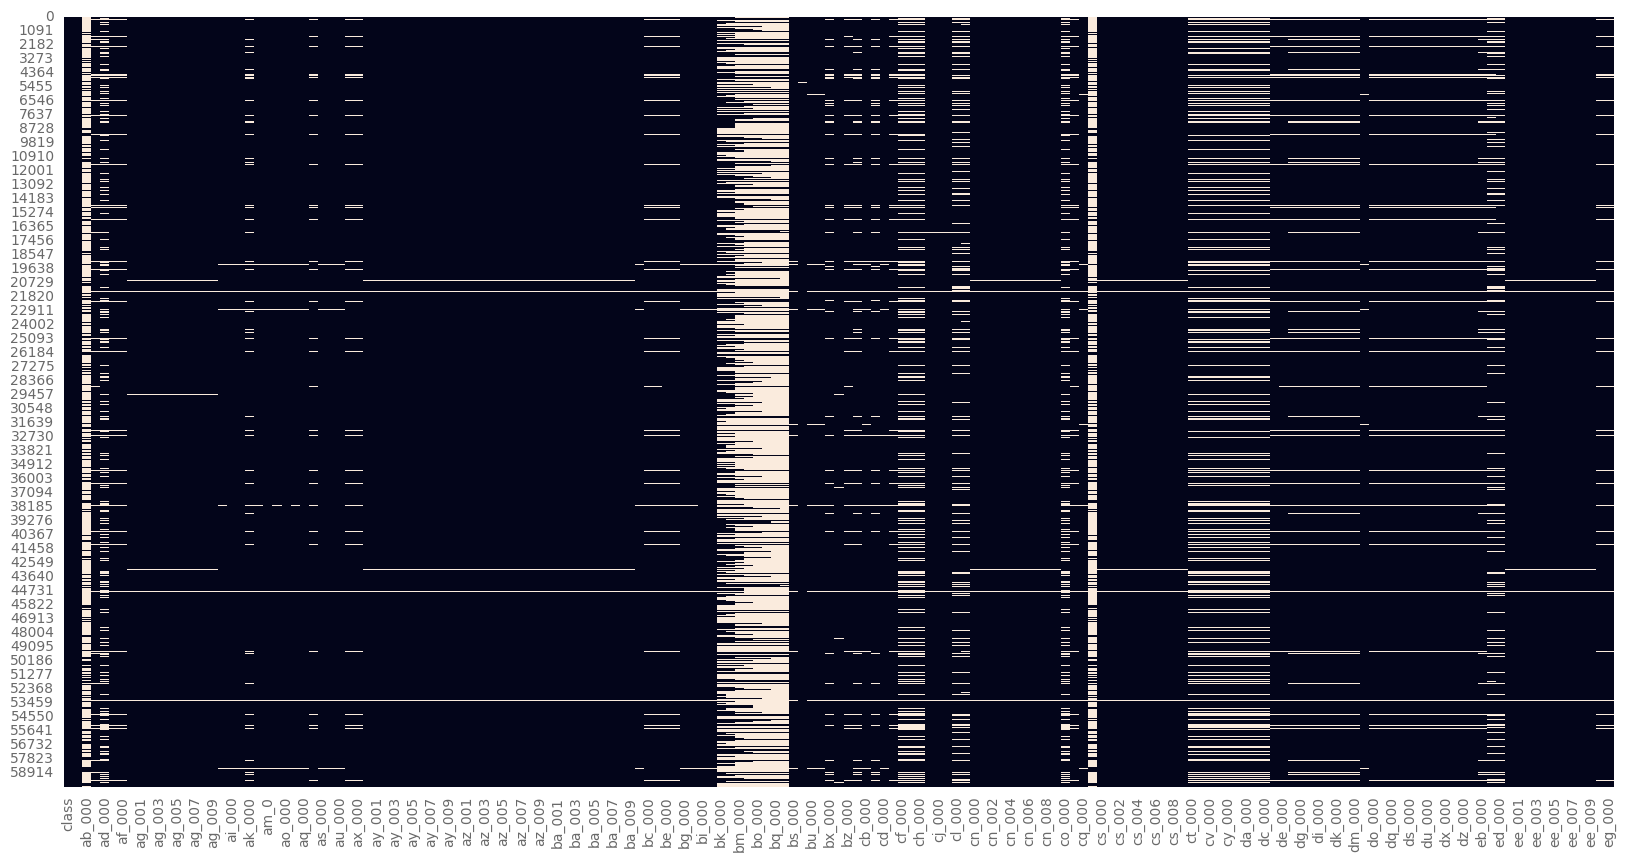

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
          ...  
cj_000      338
ci_000      338
bt_000      167
aa_000        0
class         0
Length: 171, dtype: int64

In [16]:
# About previous years dataset:
# Display null values with a heatmap figure and show null quantity in ascending order

plt.figure(figsize=(20, 10))
sns.heatmap(df_prev.isnull(), cbar=False)
plt.show()

display(df_prev.isnull().sum().sort_values(ascending= False))

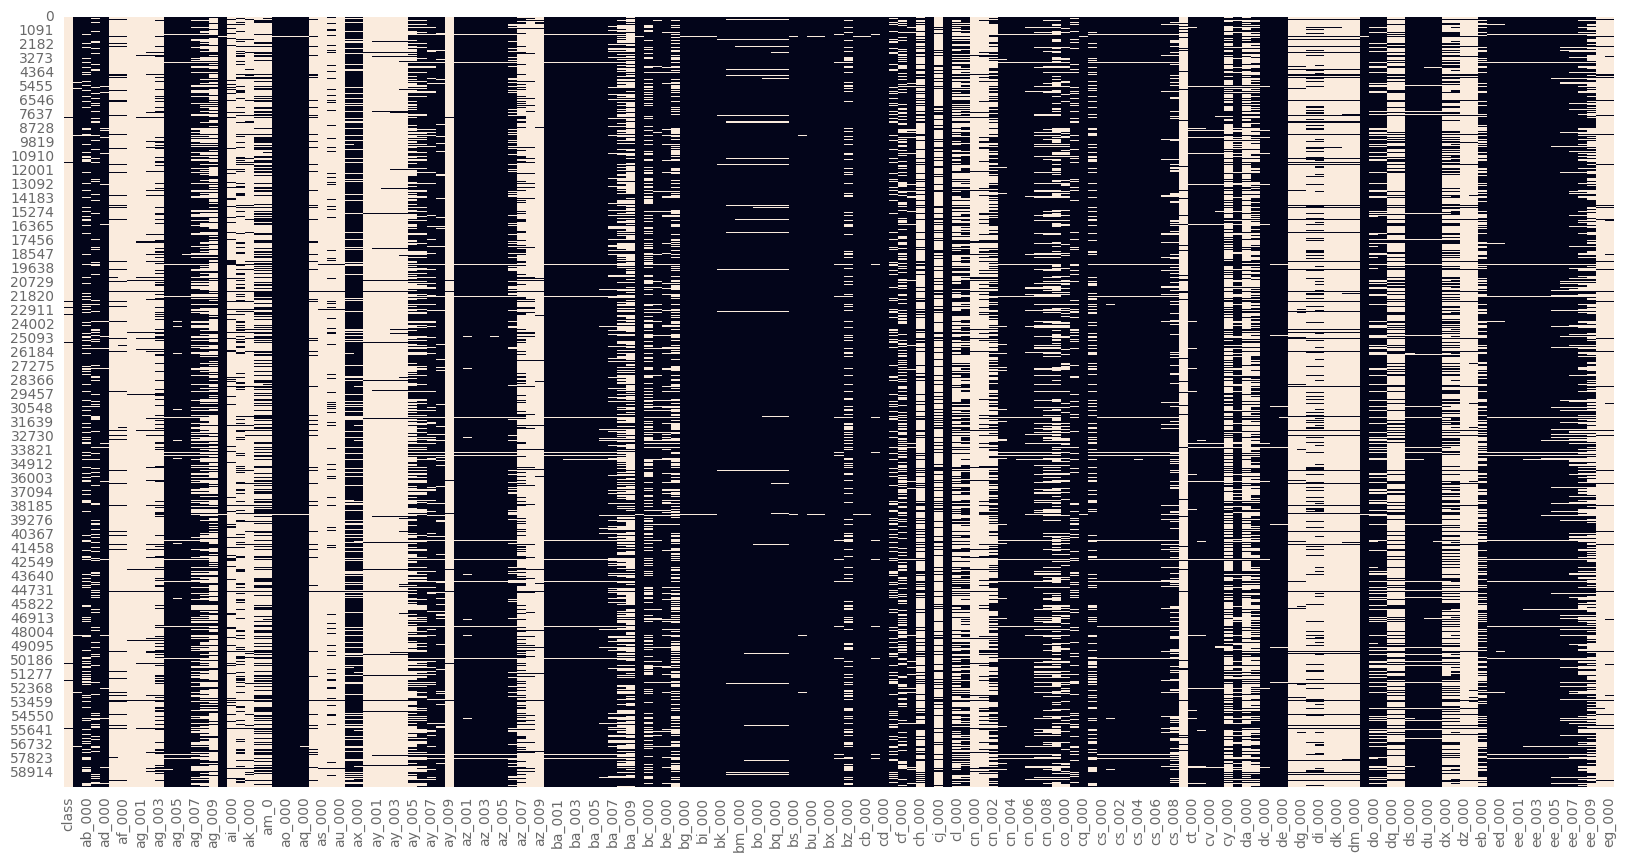

as_000    59350
au_000    59310
ag_000    59133
class     59000
ay_009    58789
          ...  
dn_000      107
cq_000      107
bb_000      107
bx_000        0
cd_000        0
Length: 171, dtype: int64

In [17]:
# Visualize the sparcity of zeros

count_zeros = (df_prev == 0)

plt.figure(figsize=(20, 10))
sns.heatmap(count_zeros, cbar= False)
plt.show()

display(count_zeros.sum().sort_values(ascending= False))

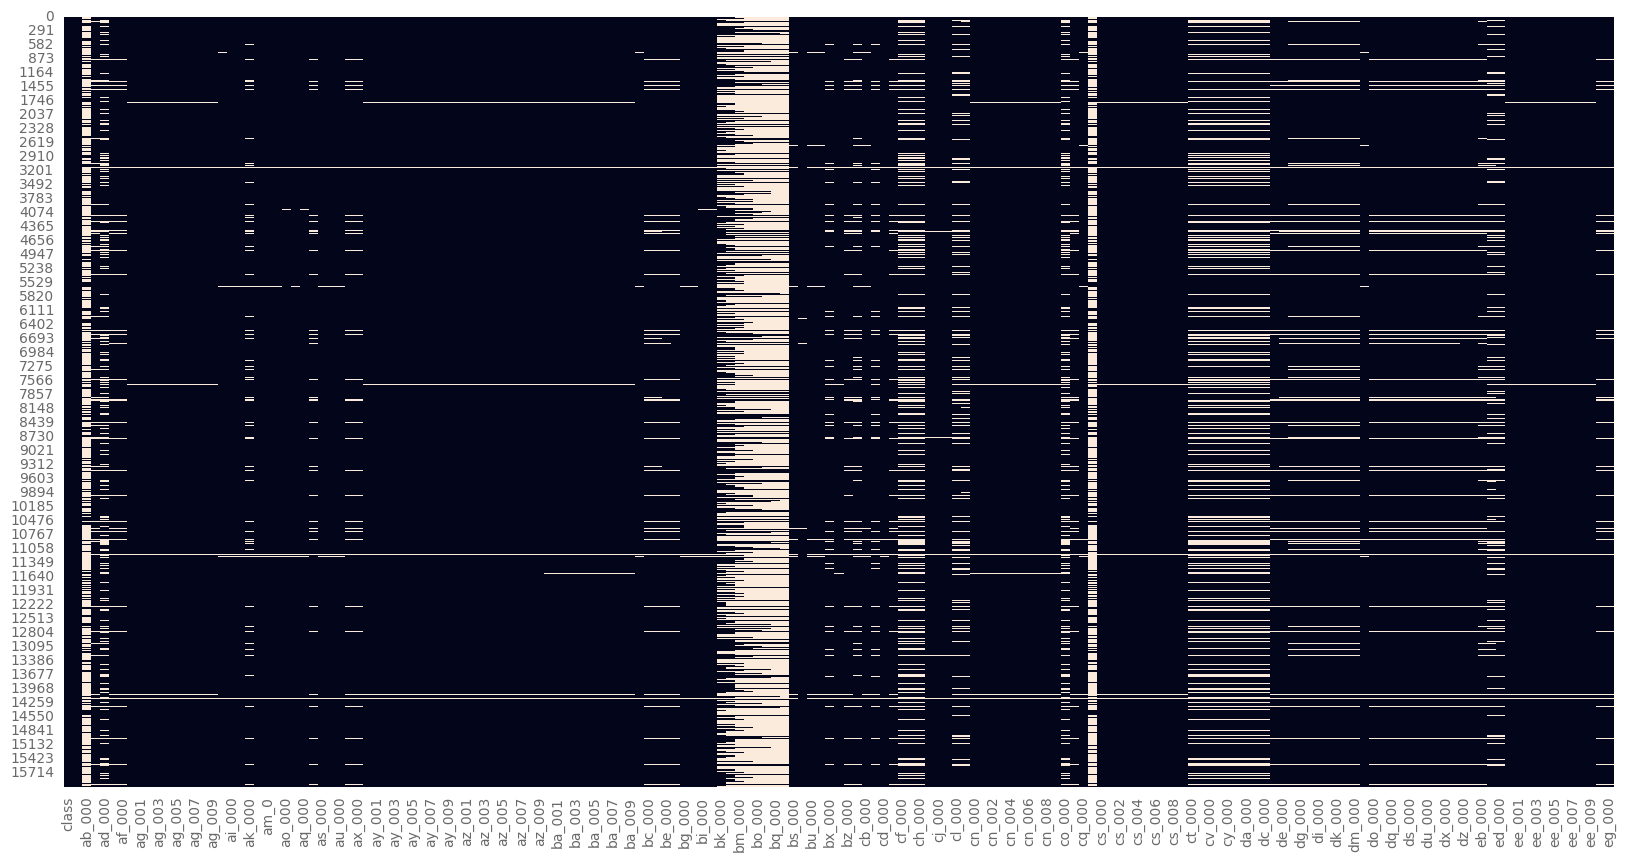

br_000    13129
bq_000    12981
bp_000    12721
bo_000    12376
ab_000    12363
          ...  
cj_000       86
ci_000       86
bt_000       28
aa_000        0
class         0
Length: 171, dtype: int64

In [18]:
# About current year dataset:
# Display null values with a heatmap figure and show null quantity in ascending order

plt.figure(figsize=(20, 10))
sns.heatmap(df_curr.isnull(), cbar=False)
plt.show()

display(df_curr.isnull().sum().sort_values(ascending= False))

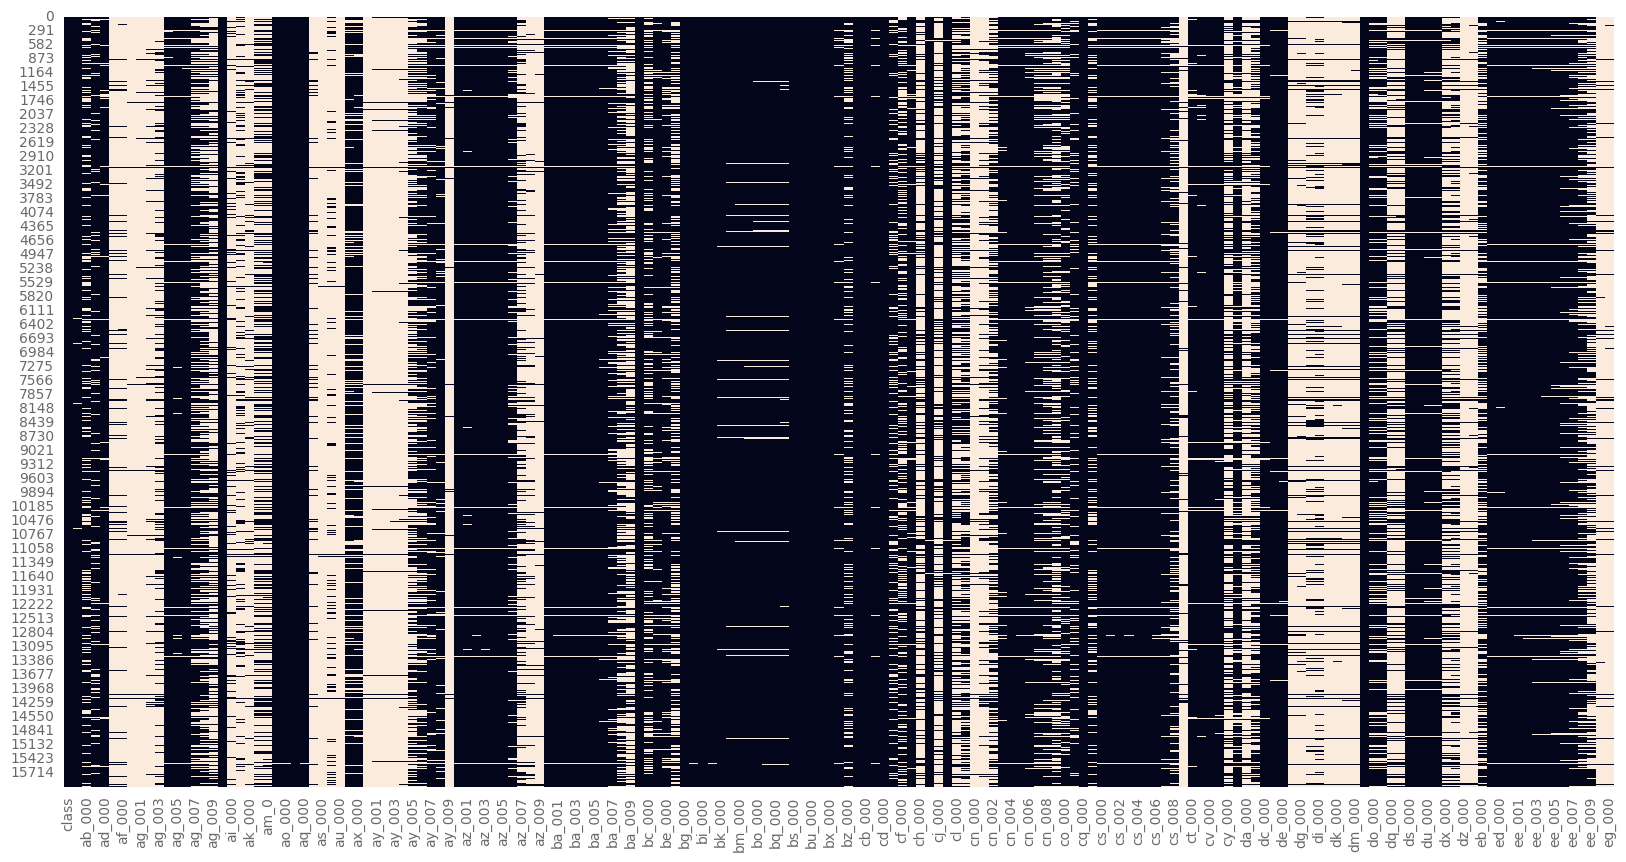

as_000    15828
au_000    15819
ag_000    15749
ay_000    15647
ay_009    15643
          ...  
ca_000       26
cb_000       26
cd_000        0
bx_000        0
class         0
Length: 171, dtype: int64

In [19]:
# Visualize the sparcity of zeros in current year

count_zeros = (df_curr == 0)

plt.figure(figsize=(20, 10))
sns.heatmap(count_zeros, cbar= False)
plt.show()

display(count_zeros.sum().sort_values(ascending= False))

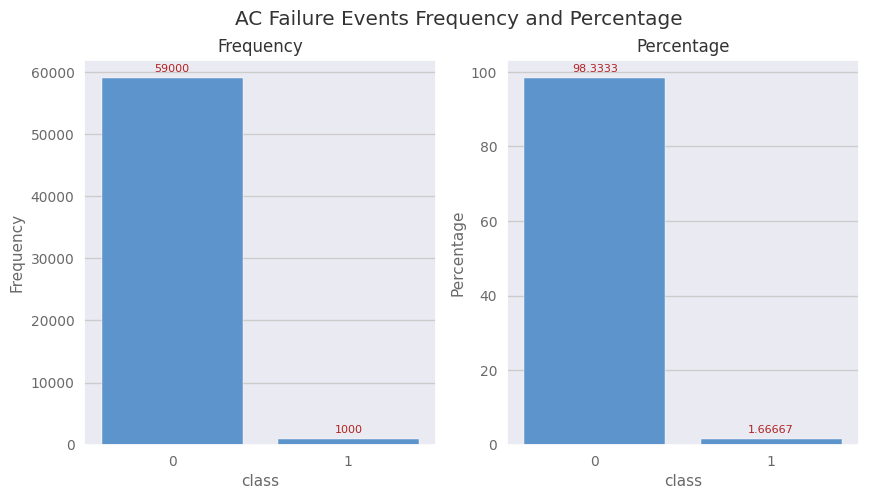

Failure  Frequency  Percentage
class                         
0            59000   98.333333
1             1000    1.666667


In [20]:
# Compare cases of pos and neg in the column 'class' in quantity and percentage

class_counts = df_prev['class'].value_counts()

class_percent = df_prev['class'].value_counts(normalize=True) * 100

freq = pd.DataFrame({'Frequency':class_counts, 'Percentage': class_percent})
freq.rename_axis('Failure', axis='columns', inplace=True)

# Plot charts in sns showing these information

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('AC Failure Events Frequency and Percentage')
axes[0].set_title('Frequency')
axes[1].set_title('Percentage')
ax1 = sns.barplot(x=freq.index, y=freq['Frequency'], ax=axes[0])
ax2 = sns.barplot(x=freq.index, y=freq['Percentage'], ax=axes[1])

ax1.bar_label(ax1.containers[0], fontsize= 8, color= 'firebrick', padding= 3)
ax2.bar_label(ax2.containers[0], fontsize= 8, color= 'firebrick', padding= 3)

plt.show()
print(freq)


#### Unbalanced Classes

  * This chart shows that this dataset is highly unbalanced. There is only 1.6 percent of positive class cases (1k in 60K cases). The choosen model will have to use weighted classes to make predictions accurately.

  #### The Curse of Dimensionality
  
  * As we can see in the previous charts, there are many columns with severe data sparcity in these datasets.

  * There are two different kinds of data sparcity in this case: **null values and zero values**

  * There should be different strategies to deal with each kind of data sparcity.
  
  1 - When dealing with null values we can use a feature selection based on missing value ratio. Variables above a defined threshold level of missing values can be eliminated as they fail to provide relevant and reliable information
  
  2 - When dealing with zero values, one of the possible strategies to eliminate features is using a low variance filter. It involves, also, defining a threshold of acceptable variance and removing the columns that has less variation than the threshold, as its low variance characteristics do not impact the target variable.

  3 - High dimensionality and sparcity will probably lead the model to overfit, besides consuming  alot of computational resources and time to run the models.


### Feature Importances and Dimensional Reduction Strategies

  * Several strategies to deal with these problems must be applied together to achieve the best possible results:

  * **Filter Strategies**

  1 - Calculate missing values tax per column and define a threshold to exclude columns with many null entries.

  2 - Calculate coefficient of variation for each column (except 'class', which is the target) and also define a threshold to exclude columns with low variation.

  3 - Exclude highly correlated columns to avoid multicolinearity.

  4 - Compute high sparse columns with many zeros.

  * **Feature Importance Selection Algorithms**

  5 - Decision Tree model feature selection, as this a simple and explicable model that can select the most important features when splitting the data into desired categories.

  6 - Recursive Feature Selection after all, as this is a very computationally intensive method, but very efficient, and should be used with fewer columns as possible to be faster.



In [21]:
# Compute missing values per column in percentage and drop all columns that have more than 75% missing values

def missing_values_rate(df, threshold):

  df = df.drop('class', axis=1)
  missing_percent = df.isnull().sum() / len(df) * 100
  missing_cols = missing_percent[missing_percent > threshold * 100].index.tolist()
  return missing_cols

In [22]:
# Aplying the function to drop columns with more than 75% of null values

missing_values_rate(df_prev, 0.75)


['ab_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']

In [23]:
# Define a function to calculate the coefficient of variation for each column, except 'class', store the columns with coefficients equal or less than 1 in a variable

def calculate_coefficient_of_variation(df, threshold):

  # Exclude 'class' column and normalize df before computing coefficients
  cols_to_calculate = df.columns[df.columns != 'class']
  scaler = StandardScaler()
  df_normalized = scaler.fit_transform(df[cols_to_calculate])

  # Calculate the coefficient of variation for each column
  coeff_var = df[cols_to_calculate].apply(lambda x: np.std(x) / np.mean(x) if np.mean(x) != 0 else np.nan)

  # Get columns with coefficient of variation equals to 1
  low_var_cols = coeff_var[coeff_var <= threshold].index.tolist()

  return low_var_cols


In [24]:
# Apply the function to the DataFrame

calculate_coefficient_of_variation(df_prev, 1)


['bk_000',
 'bl_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'ca_000',
 'cb_000',
 'cd_000']

In [25]:
# Define a function to filter high correlated columns, to avoid multicolinearity

def high_correlated_columns(df, threshold):

    # Calculate the correlation matrix excluding 'class' column
    df = df.drop(columns= 'class')
    corr_matrix = df.corr()

    # Get the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find the columns with correlation greater than the threshold
    high_corr_cols = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

    return high_corr_cols


In [26]:
# Aplying high correlated columns filter function

high_corr_cols = high_correlated_columns(df_prev, 0.80)

display(f"There are {len(high_corr_cols)} columns with very correlated data")
display(high_corr_cols)

'There are 69 columns with very correlated data'

['af_000',
 'ag_004',
 'ag_007',
 'ah_000',
 'ak_000',
 'am_0',
 'an_000',
 'ao_000',
 'ap_000',
 'aq_000',
 'ay_003',
 'az_005',
 'ba_000',
 'ba_001',
 'ba_002',
 'ba_003',
 'ba_004',
 'ba_005',
 'ba_006',
 'bb_000',
 'bg_000',
 'bh_000',
 'bi_000',
 'bj_000',
 'bl_000',
 'bm_000',
 'bn_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'bt_000',
 'bu_000',
 'bv_000',
 'bx_000',
 'by_000',
 'cb_000',
 'cc_000',
 'cf_000',
 'ci_000',
 'ck_000',
 'cn_001',
 'cn_002',
 'cn_003',
 'cn_004',
 'cn_005',
 'cn_006',
 'co_000',
 'cq_000',
 'cs_000',
 'cs_002',
 'cs_003',
 'cs_005',
 'cx_000',
 'cz_000',
 'dc_000',
 'dm_000',
 'dn_000',
 'dp_000',
 'ds_000',
 'dt_000',
 'dv_000',
 'ec_00',
 'ed_000',
 'ee_000',
 'ee_001',
 'ee_002',
 'ee_003',
 'ee_004']

In [27]:
'''
# Define a function to filter high sparcity columns (columns with many zeros) above a threshold

def many_zero_columns(df, threshold):

  df = df.drop('class', axis=1)
  zero_percent = (df == 0).sum() / len(df) * 100
  cols_zero = zero_percent[zero_percent > threshold * 100].index

  return cols_zero

'''

"\n# Define a function to filter high sparcity columns (columns with many zeros) above a threshold\n\ndef many_zero_columns(df, threshold):\n\n  df = df.drop('class', axis=1)\n  zero_percent = (df == 0).sum() / len(df) * 100\n  cols_zero = zero_percent[zero_percent > threshold * 100].index\n\n  return cols_zero\n  \n"

In [28]:
'''
# Applying the function

cols_zero = many_zero_columns(df_prev, 0.75)

display(f"There are {len(cols_zero)} columns with more than 75% of the information consisting of zeros")
display(cols_zero)

'''

'\n# Applying the function\n\ncols_zero = many_zero_columns(df_prev, 0.75)\n\ndisplay(f"There are {len(cols_zero)} columns with more than 75% of the information consisting of zeros")\ndisplay(cols_zero)\n\n'

#### Decision Tree Model to Compute Feature Importances

In [31]:
# Lets try a Decision Tree Model

df = df_prev_cp.copy()

X = df.drop(columns= ['class'])
y = df['class']

x_train, x_test, y_train, y_test = train_test_split( X, y, test_size= 0.3, stratify = y, random_state= 71)

# Aplying Tree based model as a baseline and to evaluate feature importances

tree = DecisionTreeClassifier(class_weight= 'balanced', max_depth= 5, random_state= 71)

tree.fit(x_train, y_train)

feat_imp = pd.Series(tree.feature_importances_, index=x_train.columns).sort_values(ascending=False)

top_feat = feat_imp[:10]
all_feat = feat_imp[::]

print(top_feat, end= '\n')
print(all_feat)

aa_000    0.784829
al_000    0.157623
cj_000    0.016279
az_001    0.013837
ay_002    0.007177
cu_000    0.005239
ee_006    0.004141
cm_000    0.003410
bd_000    0.003275
aj_000    0.002047
dtype: float64
aa_000    0.784829
al_000    0.157623
cj_000    0.016279
az_001    0.013837
ay_002    0.007177
            ...   
az_002    0.000000
az_000    0.000000
ay_009    0.000000
ay_008    0.000000
eg_000    0.000000
Length: 96, dtype: float64


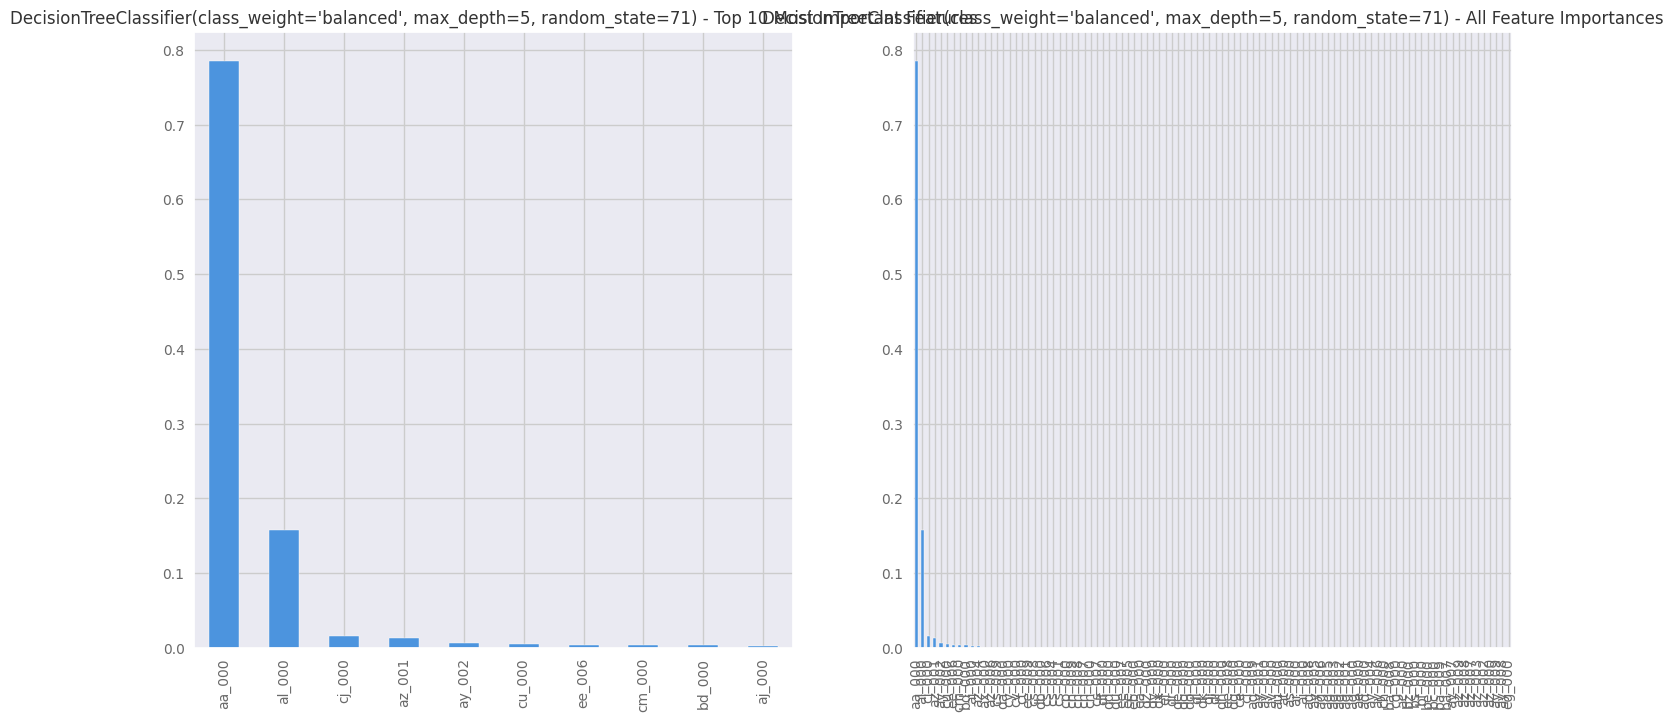

In [32]:
# Plot charts with feature importances

fig, axes = plt.subplots(1,2, figsize=(17,8))
top_feat.plot(kind='bar', ax=axes[0])
all_feat.plot(kind='bar', ax=axes[1])
axes[0].set_title(f"{tree} - Top 10 Most Important Features")
axes[1].set_title(f"{tree} - All Feature Importances")

plt.show()

In [37]:
# Find the features with zero importance

zero_features = pd.Series(feat_imp == 0)

print(f'There are {len(zero_features[zero_features == True])} features with 0.0 importance')


There are 83 features with 0.0 importance


  * There are 83 from 96 columns that are considered to be 0 feature importance

#### Using Recursive Feature Selection

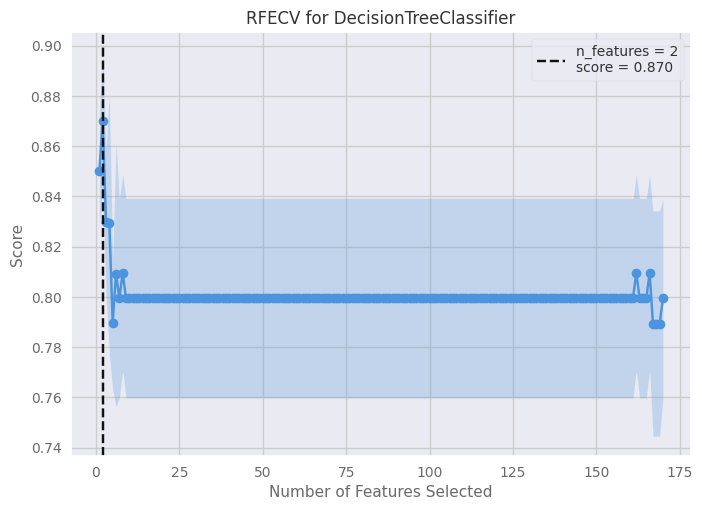

Execution time: 95.92343936363856 minutos


In [44]:
# Using decision tree and RFE with yellowbricks wrapper to analyse number of features that can be selected
# Test with Recall as metrics in all 171 columns

start_time = time.time()

df = df_prev
cv = StratifiedKFold(3)

X, y = df.drop('class', axis=1), df['class']

imputer = SimpleImputer(missing_values= np.nan, strategy= 'median')
X = pd.DataFrame(imputer.fit_transform(X), columns= X.columns)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)

# Select a balanced sample to reduce computational resources
# 10% of the "population"
sample_size= 6000
sample_X, sample_y = resample (X, y, n_samples= sample_size, stratify= y, random_state= 71)

visualizer = RFECV(tree, cv= cv, scoring= 'recall')

# Fit the data to the visualizer
visualizer.fit(sample_X, sample_y)

# Finalize and render the figure
visualizer.show()

end_time= time.time()
print(f'Execution time: {(end_time - start_time) / 60} minutos')

In [48]:
# Extract feature importances

feature_importances = visualizer.estimator_.feature_importances_
selected_features = visualizer.support_
ranking = visualizer.ranking_

# Create a DataFrame to store the results
feature_importance_df = pd.DataFrame({'Feature': sample_X.columns[selected_features],
                                      'Importance': feature_importances,
                                      'Selected': selected_features[selected_features],
                                      'Ranking': ranking[selected_features]})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(feature_importance_df)

  Feature  Importance  Selected  Ranking
0  ci_000    0.955326      True        1
1  dn_000    0.044674      True        1


In [47]:
# Show all columns by ranking

feature_ranking = pd.DataFrame({'Columns': sample_X.columns, 'Ranking': ranking})

rank= feature_ranking.sort_values(by= 'Ranking', ascending = True)

selected_features1 = rank.Columns.tolist()[:5]

selected_features1

['ci_000', 'dn_000', 'di_000', 'aq_000', 'cs_009']

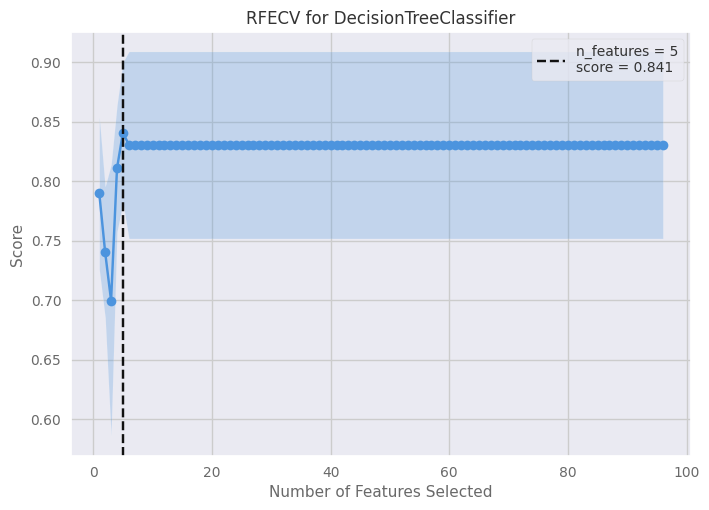

Execution time: 14.52874717315038 minutos


In [40]:
# Using decision tree and RFE with yellowbricks wrapper to analyse number of features that can be selected
# Test with Recall as metrics

start_time = time.time()

cv = StratifiedKFold(3)

X, y = df.drop('class', axis=1), df['class']

imputer = SimpleImputer(missing_values= np.nan, strategy= 'median')
X = pd.DataFrame(imputer.fit_transform(X), columns= X.columns)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)

# Select a balanced sample to reduce computational resources
# 10% of the "population"
sample_size= 6000
sample_X, sample_y = resample (X, y, n_samples= sample_size, stratify= y, random_state= 71)

visualizer = RFECV(tree, cv= cv, scoring= 'recall')

# Fit the data to the visualizer
visualizer.fit(sample_X, sample_y)

# Finalize and render the figure
visualizer.show()

end_time= time.time()
print(f'Execution time: {(end_time - start_time) / 60} minutos')

In [41]:
# Extract feature importances

feature_importances = visualizer.estimator_.feature_importances_
selected_features = visualizer.support_
ranking = visualizer.ranking_

# Create a DataFrame to store the results
feature_importance_df = pd.DataFrame({'Feature': sample_X.columns[selected_features],
                                      'Importance': feature_importances,
                                      'Selected': selected_features[selected_features],
                                      'Ranking': ranking[selected_features]})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(feature_importance_df)

  Feature  Importance  Selected  Ranking
0  aa_000    0.900848      True        1
2  az_000    0.048194      True        1
4  eb_000    0.021383      True        1
1  ay_007    0.017139      True        1
3  cs_009    0.012436      True        1


In [42]:
# Show all columns by ranking

feature_ranking = pd.DataFrame({'Columns': sample_X.columns, 'Ranking': ranking})

rank= feature_ranking.sort_values(by= 'Ranking', ascending = True)

selected_features2 = rank.Columns.tolist()[:5]

selected_features2


['aa_000', 'cs_009', 'az_000', 'ay_007', 'eb_000']

In [69]:
# Compare the results of missing values rate, coefficient of variation, high correlated columns and high sparcity columns with selected columns from algorithms

missing_cols = missing_values_rate(df_prev, 0.75)
low_var_cols = calculate_coefficient_of_variation(df_prev, 1)
high_corr_cols = high_correlated_columns(df_prev, 0.80)
#cols_zero = many_zero_columns(df_prev, 0.75)

# How many columns are filtered in the given conditions?
# Use set union to combine the lists and avoid duplicates
less_imp_cols = set(missing_cols).union(set(low_var_cols), set(high_corr_cols)) #set(cols_zero)

imp_cols = set(selected_features1).union(set(selected_features2), set(top_feat.index))

all_cols = set(df_prev.columns) - less_imp_cols
all_selected_cols = list(all_cols.union(set(imp_cols)))

print(f' There are {len(all_selected_cols)} columns that belongs to these conditions')


 There are 100 columns that belongs to these conditions


In [73]:
all_selected_cols = list(all_cols.union(set(imp_cols)))

  * From the 171 columns that were originally presented, 109 were selected as low importance columns.

  * It means that 62 columns can be useful to the prediction model as they probably contain the most important data and must be preserved.

  * All 109 columns could be dropped as they do not brings useful information to the prediction model

In [74]:
all_selected_cols

['dy_000',
 'cs_006',
 'cl_000',
 'ea_000',
 'aq_000',
 'ag_008',
 'ag_003',
 'aa_000',
 'cj_000',
 'az_004',
 'aj_000',
 'ag_001',
 'bc_000',
 'dk_000',
 'ag_000',
 'cu_000',
 'at_000',
 'cm_000',
 'ax_000',
 'cn_008',
 'ag_006',
 'ee_006',
 'az_000',
 'dr_000',
 'ay_008',
 'al_000',
 'dq_000',
 'dd_000',
 'di_000',
 'cv_000',
 'ac_000',
 'ee_005',
 'az_006',
 'cs_004',
 'dn_000',
 'cn_009',
 'dl_000',
 'dz_000',
 'ay_000',
 'ay_007',
 'db_000',
 'ay_001',
 'cy_000',
 'de_000',
 'be_000',
 'ag_005',
 'ce_000',
 'ay_005',
 'dx_000',
 'eg_000',
 'cp_000',
 'cs_008',
 'az_007',
 'cs_009',
 'ci_000',
 'ay_009',
 'ba_008',
 'ag_009',
 'ae_000',
 'bf_000',
 'bd_000',
 'ef_000',
 'ee_009',
 'az_009',
 'as_000',
 'au_000',
 'cn_000',
 'cs_007',
 'dh_000',
 'bz_000',
 'do_000',
 'az_001',
 'du_000',
 'cn_007',
 'df_000',
 'ag_002',
 'cs_001',
 'ee_008',
 'av_000',
 'ay_006',
 'ay_002',
 'az_008',
 'ad_000',
 'ct_000',
 'ba_007',
 'ai_000',
 'ay_004',
 'ar_000',
 'dg_000',
 'ee_007',
 'az_002',

In [75]:
# Lets make a dataset with selected columns and look to the heatmap again to better understand the effectivenes ofg the feature selection strategy

df_prev_selected = df_prev[all_selected_cols].copy()

df_prev_selected.sample(5)


dy_000     cs_006  cl_000  ea_000    aq_000   ag_008  ag_003  aa_000  \
33836     0.0  1287386.0     0.0     0.0  345016.0  53554.0     0.0   41386   
54493     0.0   629346.0     NaN     0.0  370858.0   2400.0     0.0   32850   
1022      0.0   249882.0     0.0     0.0  233840.0  15692.0     0.0   39358   
15394   110.0     7966.0     6.0     0.0    2188.0      0.0     0.0      74   
23902     0.0   683618.0     0.0     0.0  386908.0  44650.0     0.0   61178   

       cj_000     az_004  ...  az_002  class  da_000     eb_000    bs_000  \
33836     0.0   229632.0  ...  3088.0      0     NaN  1385640.0   31380.0   
54493     0.0   804862.0  ...  1608.0      0     NaN  3902360.0  265040.0   
1022      0.0   195680.0  ...  1206.0      0     0.0        0.0   39860.0   
15394     0.0      114.0  ...    20.0      0     0.0        0.0   24600.0   
23902     0.0  3145210.0  ...  3646.0      0     0.0  1368230.0  176080.0   

       ba_009  dj_000  cg_000  ch_000    az_003  
33836     0.0     0.0     NaN     NaN    2724.0  
54493     0.0     0.0     NaN     NaN    2262.0  
1022      0.0     0.0    30.0     0.0    2020.0  
15394    18.0     0.0    10.0     0.0      34.0  
23902     0.0     0.0   108.0     0.0  536240.0  

[5 rows x 100 columns]

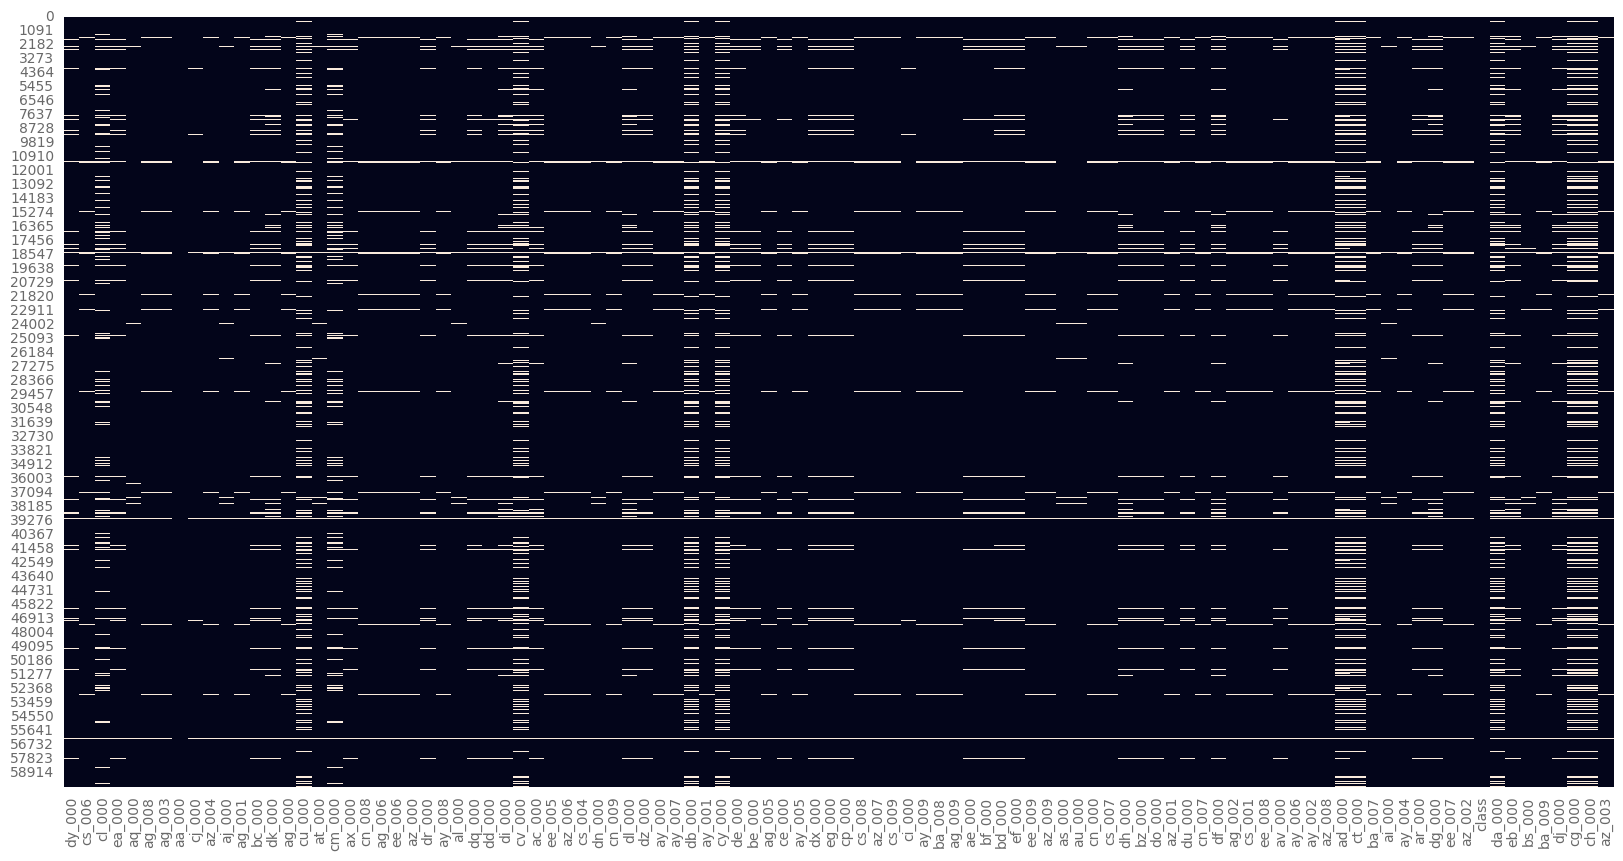

ch_000    14861
cg_000    14861
ad_000    14861
cy_000    13808
cv_000    13808
          ...  
aq_000      589
cj_000      338
ci_000      338
class         0
aa_000        0
Length: 100, dtype: int64

In [77]:
# Plot heatmap to evaluate strategy looking to null values

plt.figure(figsize=(20, 10))
sns.heatmap(df_prev_selected.isnull(), cbar=False)
plt.show()

display(df_prev_selected.isnull().sum().sort_values(ascending= False))

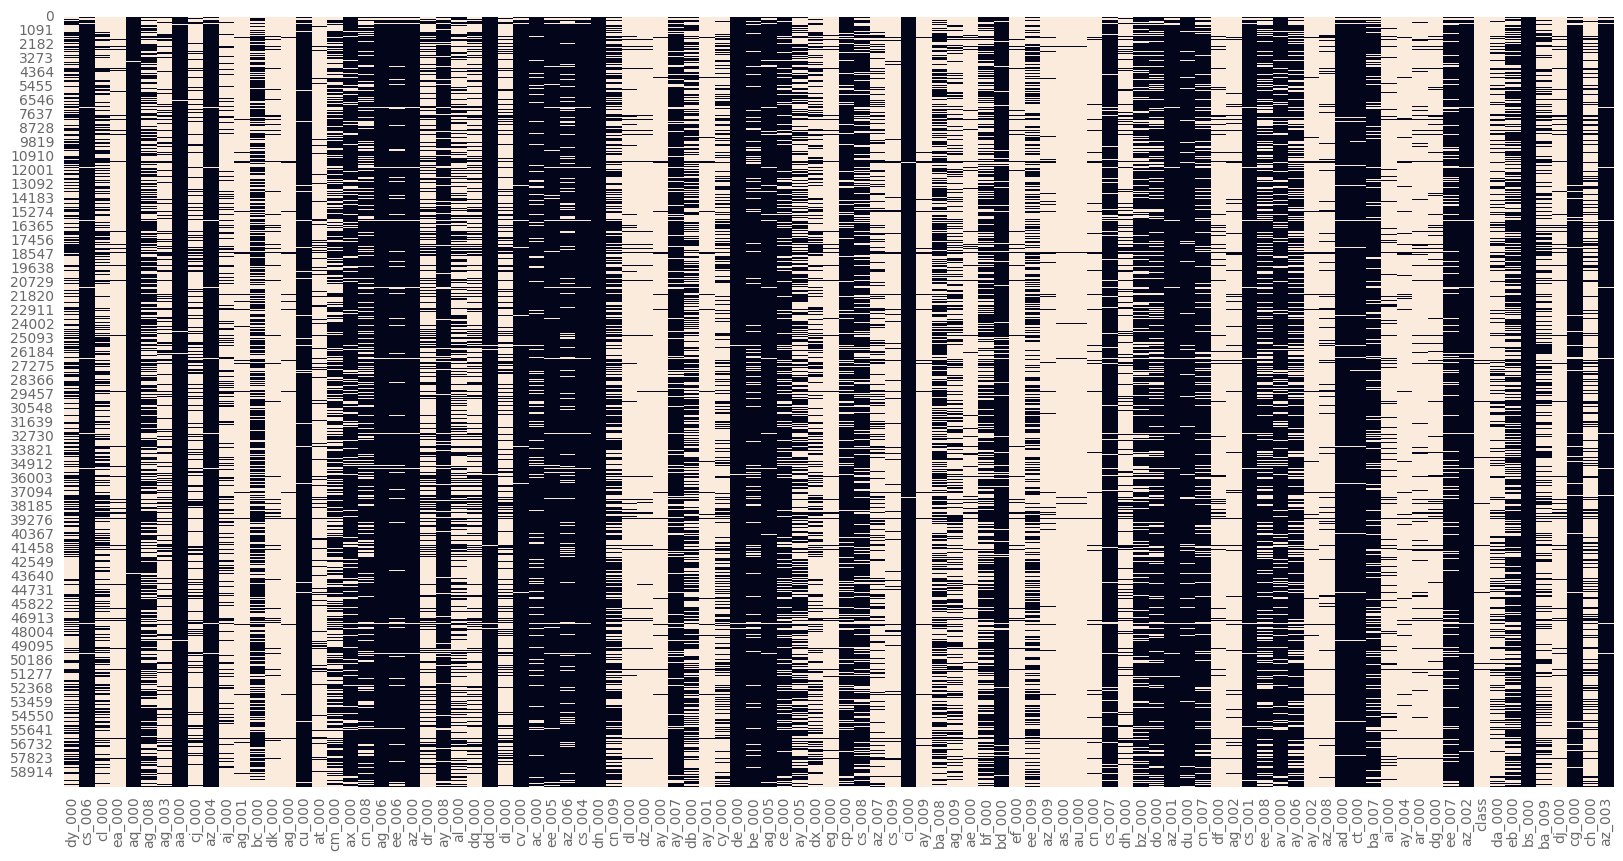

as_000    59350
au_000    59310
ag_000    59133
class     59000
ay_009    58789
          ...  
aa_000      393
aq_000      230
ci_000      223
bs_000      120
dn_000      107
Length: 100, dtype: int64

In [78]:
# Plot heatmap to evaluate strategy looking to zero values (sparcity)

count_zeros = (df_prev_selected == 0)

plt.figure(figsize=(20, 10))
sns.heatmap(count_zeros, cbar= False)
plt.show()

display(count_zeros.sum().sort_values(ascending= False))

#### Analysis of the Sparcity After Feature Filter Selection

  * The heatmaps now demonstrates how the sparcity related to null values were reduced.

  * But the second chart is still sparse with many zero values, and it continues to be a problem

  * But, in some aspects, the absence of information is a possible information, so lets continue with the second part of the feature reduction strategy.

### Machine Learning Models

In [79]:
# Define a function to impute values to NaN
# Using Median as distribution is skewed

def impute_median(x_train, x_test):

  imputer = SimpleImputer(missing_values= np.nan, strategy= 'median')

  x_train = pd.DataFrame(imputer.fit_transform(x_train), columns= x_train.columns)
  x_test = pd.DataFrame(imputer.transform(x_test), columns= x_test.columns)

  return x_train, x_test


In [80]:
# Define a function to scale values as ranges are very different between columns

def standard_scaler(x_train, x_test):

  scaler = StandardScaler()

  x_train = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

  return x_train, x_test


In [81]:
# Define a function to apply model
def model_apply (model, x_train, x_test, y_train):
  print('Applying Model')
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  return y_pred

# Define a function to evaluate model
def evaluate_model (y_test, y_pred, model):
  print('Evaluating Results')
  accuracy = accuracy_score(y_test, y_pred) * 100
  recall = recall_score(y_test, y_pred, pos_label= 1) * 100
  print(f"Test Sample Accuracy: {accuracy}\n")
  print(f"Test Sample Recall: {recall}\n")
  print(f"Sample Train Score (comparative): {model.score(x_train, y_train)}\n")
  print(classification_report(y_test, y_pred))

  fig, axes = plt.subplots(1,2, figsize=(13,6))
  sns.heatmap(confusion_matrix(y_test, y_pred), fmt= 'g', cmap='tab20c', annot=True,cbar=False, ax=axes[0])
  sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), fmt= 'g', cmap='tab20c', annot=True, cbar=False, ax=axes[1])
  fig.suptitle('Confusion Matrix', fontsize=16, y=0.95)
  axes[0].set_title('Failure Quantity')
  axes[1].set_title('Failure Percentual')
  axes[0].set_xlabel('P R E D I C T')
  axes[0].set_ylabel('R E A L')
  axes[1].set_xlabel('P R E D I C T')
  axes[1].set_ylabel('R E A L')
  axes[0].set_xticklabels(['Negative', 'Positive'])
  axes[0].set_yticklabels(['Negative', 'Positive'])
  axes[1].set_xticklabels(['Negative', 'Positive'])
  axes[1].set_yticklabels(['Negative', 'Positive'])
  plt.show()

  if type(model) == DecisionTreeClassifier:
    plt.figure(figsize=(25, 12))
    plot_tree(model, filled= True)
    plt.show()

# Define a function to evaluate feature importances
def feature_importance (model):
  if model in eval_feat_importance:
    feat_imp = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    top_feat = feat_imp[:6]
    all_feat = feat_imp[::]

    fig, axes = plt.subplots(1,2, figsize=(17,8))
    top_feat.plot(kind='bar', ax=axes[0])
    all_feat.plot(kind='bar', ax=axes[1])
    axes[0].set_title(f"{model} - Top 10 Most Important Features")
    axes[1].set_title(f"{model} - All Feature Importances")
  else:
    pass

  return print('')

# Define a function to plot ROC AUC Curve
def roc_curve_auc_score (x_test, y_test, model):

  y_pred_prob = model.predict_proba(x_test)[:,1]
  model_tfp, model_tvp, _= roc_curve(y_test, y_pred_prob, pos_label= 1)

  fig, axes = plt.subplots(1, figsize=(8,8))
  plt.plot([0,1], [0,1], 'r--')
  plt.plot(model_tfp, model_tvp, label='model')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f"{model} - Roc Curve")
  plt.show()

  return print(f"AUC Score (ROC): {roc_auc_score(y_test, y_pred_prob)}\n")

# Define a function to store each models metrics
def append_results (model, y_test, y_pred, y_pred_prob):

  global accuracy, auc, f1, model_name, precision, recall
  model_name.append(model.__class__.__name__)
  precision.append(precision_score(y_test, y_pred, pos_label= 1) * 100)
  accuracy.append(accuracy_score(y_test, y_pred) * 100)
  recall.append(recall_score(y_test, y_pred, pos_label= 1) * 100)
  roc_curve_sco.append(roc_auc_score(y_test, y_pred_prob) * 100)
  f1_sco.append(f1_score(y_test, y_pred, pos_label= 1) * 100)
  log_cost.append(log_loss(y_test, y_pred) * 100)

  return print('Stored Metrics')


In [82]:
# Define a function putting all together, like a pipeline function

def pipeline (model, x_train, x_test, y_train, y_test):

  y_pred = model_apply (model, x_train, x_test, y_train)
  y_pred_prob = model.predict_proba(x_test)[:,1]
  evaluate_model (y_test, y_pred, model)
  feature_importance (model)
  roc_curve_auc_score(x_test, y_test, model)
  append_results (model, y_test, y_pred, y_pred_prob)
  y_train_score = model.predict_proba(x_train)[:, 1]

  return print('Completed Pipeline \n')

In [83]:
# Set empty lists to store tested models metrics

model_name = []
precision = []
accuracy = []
recall = []
roc_curve_sco = []
f1_sco = []
log_cost = []

resultados = []


In [85]:
# Split train and test datasets

df = df_prev_selected.copy()

X = df.drop(columns= ['class'])
y = df['class']

x_train, x_test, y_train, y_test = train_test_split( X, y, test_size= 0.3, stratify = y, random_state= 71)

x_train, x_test = impute_median (x_train, x_test)
x_train, x_test = standard_scaler (x_train, x_test)

In [86]:
# Adjust class weights for majority class 0

class_weights = {0: 1.017, 1: 59.88}


In [87]:
# Aplying to some models to test better performance


tree = DecisionTreeClassifier(class_weight= {0: 1.017, 1: 59.88}, max_depth=5, random_state= 71)

rf = RandomForestClassifier(class_weight= {0: 1.017, 1: 59.88}, random_state= 71)

log_reg = LogisticRegression(class_weight= {0: 1.017, 1: 59.88}, random_state= 71)

xgboostclassifier = XGBClassifier(scale_pos_weight= (y_train.value_counts()[0] / y_train.value_counts()[1]), random_state=71)

lgbm = LGBMClassifier(class_weight= {0: 1.017, 1: 59.88}, random_state= 71)


models = [tree, rf, log_reg, xgboostclassifier, lgbm]

eval_feat_importance = [tree, rf, xgboostclassifier, lgbm]

opt_metric = 'f1'

In [88]:
# Set parameters to each model

tree_parameter_space = {'criterion': ['gini', 'entropy'],
                      'max_depth': [4, 5, 6, 7],
                      'min_samples_leaf': [5, 8, 10, 15, 20],
                      'min_samples_split': [2, 5, 10, 15]
                        }


rf_parameter_space = {'criterion': ['gini', 'entropy'],
                      'max_depth': [8, 9, 10, 12, 15],
                      'min_samples_leaf': [5, 8, 10, 15],
                      'min_samples_split': [20, 30, 40, 50, 75, 100],
                      'n_estimators' : [30, 40, 50, 60, 70, 80]
                      }

log_reg_parameter_space = {'penalty': ['l1','l2'],
                            'C': [0.1, 1, 2],
                            'solver': ['liblinear','saga'],
                            'max_iter': [100],
                           }


xgboost_parameter = {'learning_rate' : [.001, .01, 1],
                    'max_depth' : [5, 8, 10, 15],
                    'n_estimators' : [30, 40, 50, 60, 70, 80],
                    'gamma' : [0.8, 1, 2, 5, 7, 10],
                    'reg_alpha' : [0, 0.05, 0.1, 1],
                    'reg_lambda' : [0, 0.1, 1, 2, 5]
                    }


lgbm_parameter_space = { 'classifier__num_leaves': [20, 30, 50, 100, 150],
                         'classifier__max_depth': [3, 5, 10, 20],
                         'classifier__learning_rate': [0.05, 0.1, 0.2],
                         'classifier__n_estimators': [20, 30, 40, 50, 60],
                         'classifier__min_child_samples': [ 20, 50, 60 ,80],
                         'classifier__min_child_weight': [1e-2, 1e-1, 1, 2],
                         'classifier__subsample': [0.5, 0.8, 0.9, 1.0],
                         'classifier__colsample_bytree': [0.6, 0.8, 1.0, 2],
                         'classifier__reg_alpha': [0, 0.01, 0.1, 1, 2],
                         'classifier__reg_lambda': [0, 0.01, 0.1, 1],
                         'classifier__boosting_type': ['gbdt', 'dart', 'goss'],
                         'verbose': [-1]
                         }



####Decision Tree Model

Applying Model
Evaluating Results
Test Sample Accuracy: 95.30555555555556

Test Sample Recall: 94.0

Sample Train Score (comparative): 0.9526428571428571

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     17700
           1       0.25      0.94      0.40       300

    accuracy                           0.95     18000
   macro avg       0.63      0.95      0.69     18000
weighted avg       0.99      0.95      0.97     18000



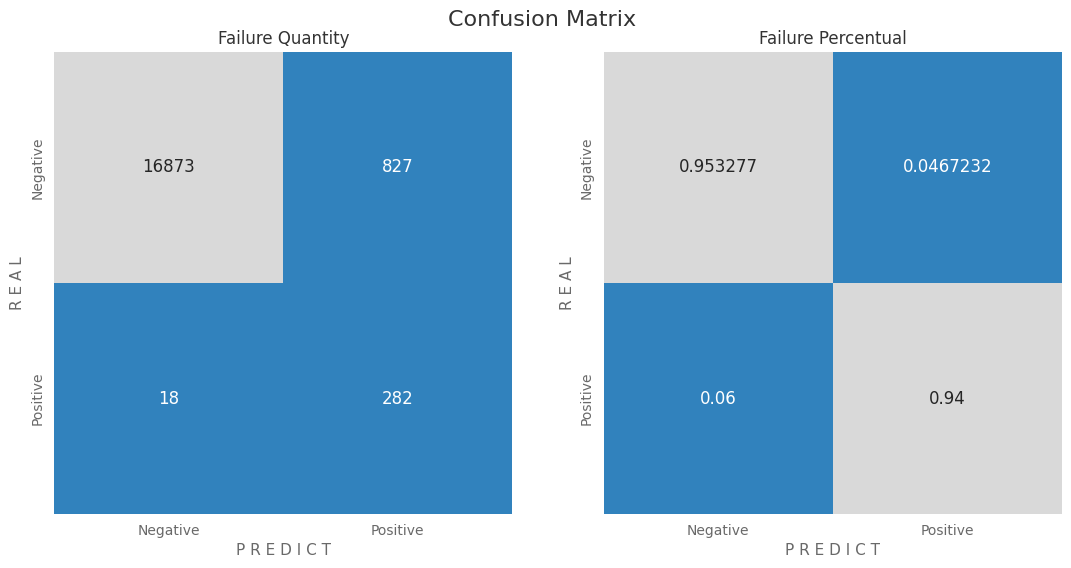

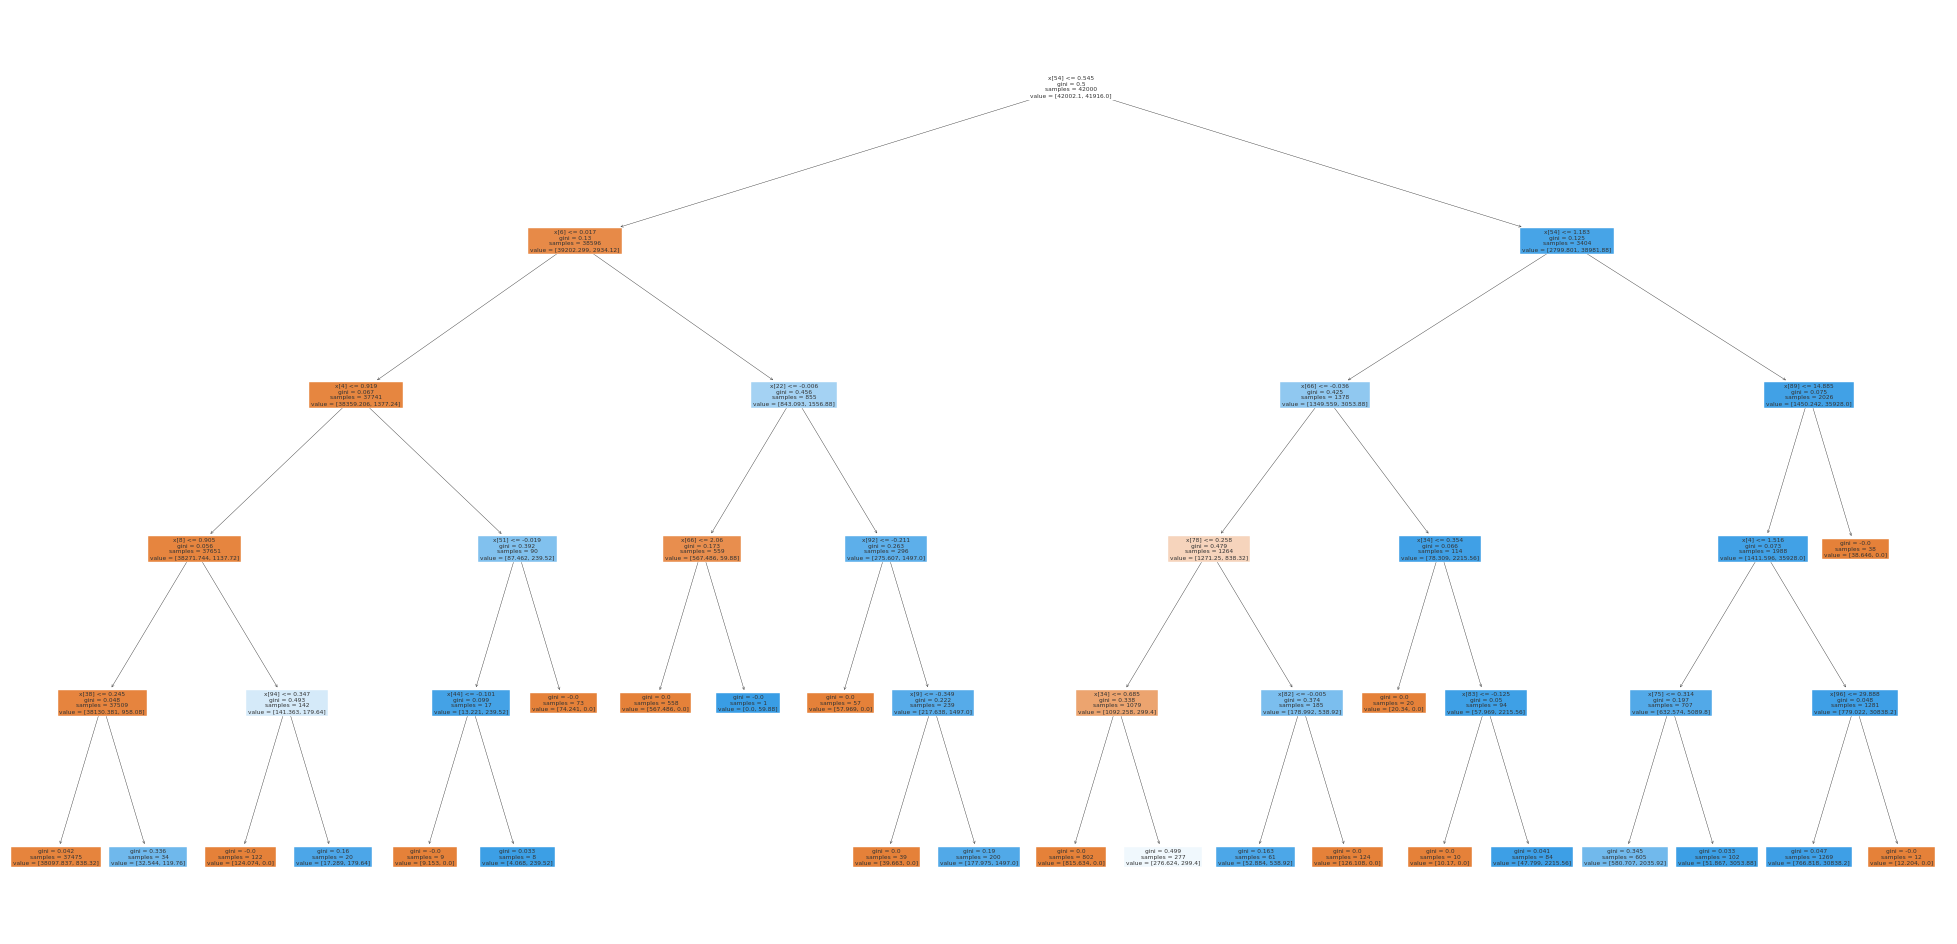

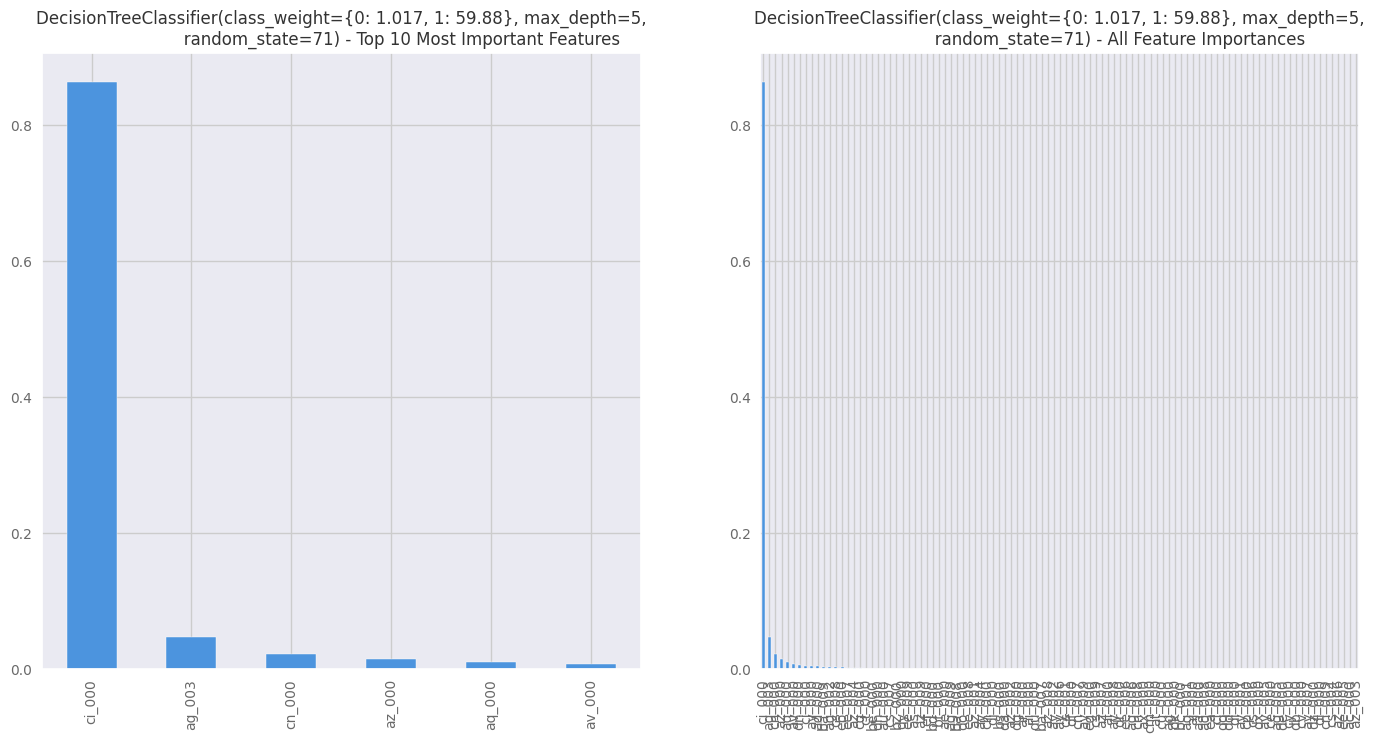

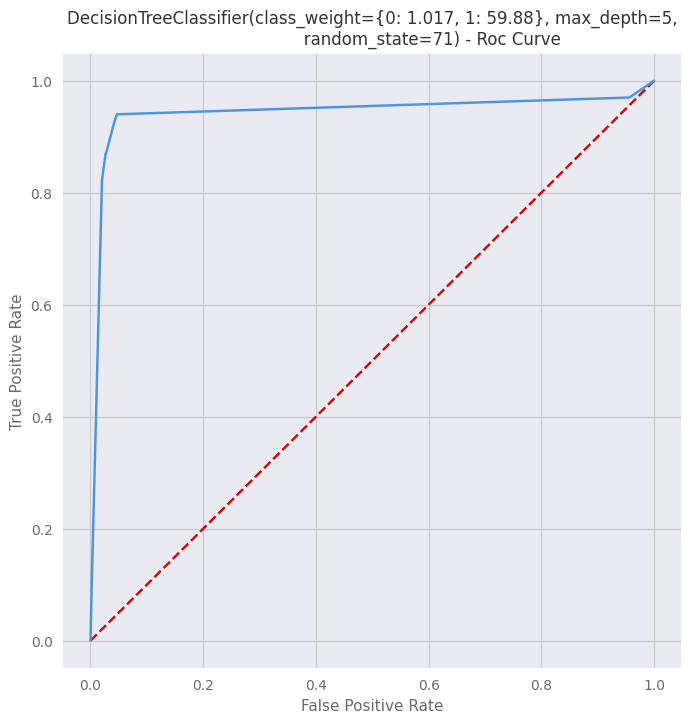

AUC Score (ROC): 0.9435706214689266

Stored Metrics
Completed Pipeline 

Applying Model
Evaluating Results
Test Sample Accuracy: 96.45

Test Sample Recall: 90.66666666666666

Sample Train Score (comparative): 0.9672142857142857

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     17700
           1       0.31      0.91      0.46       300

    accuracy                           0.96     18000
   macro avg       0.65      0.94      0.72     18000
weighted avg       0.99      0.96      0.97     18000



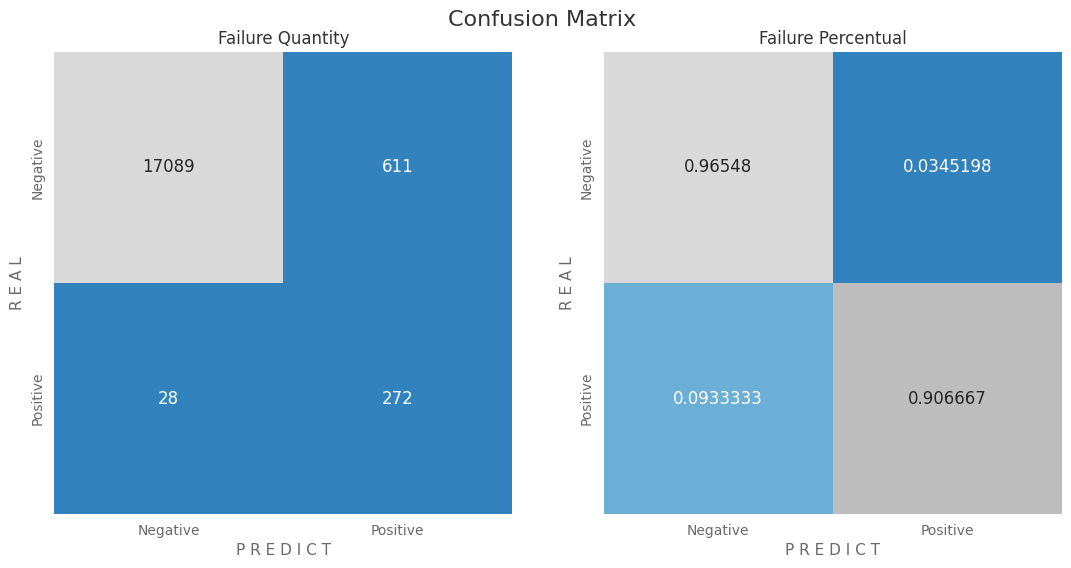

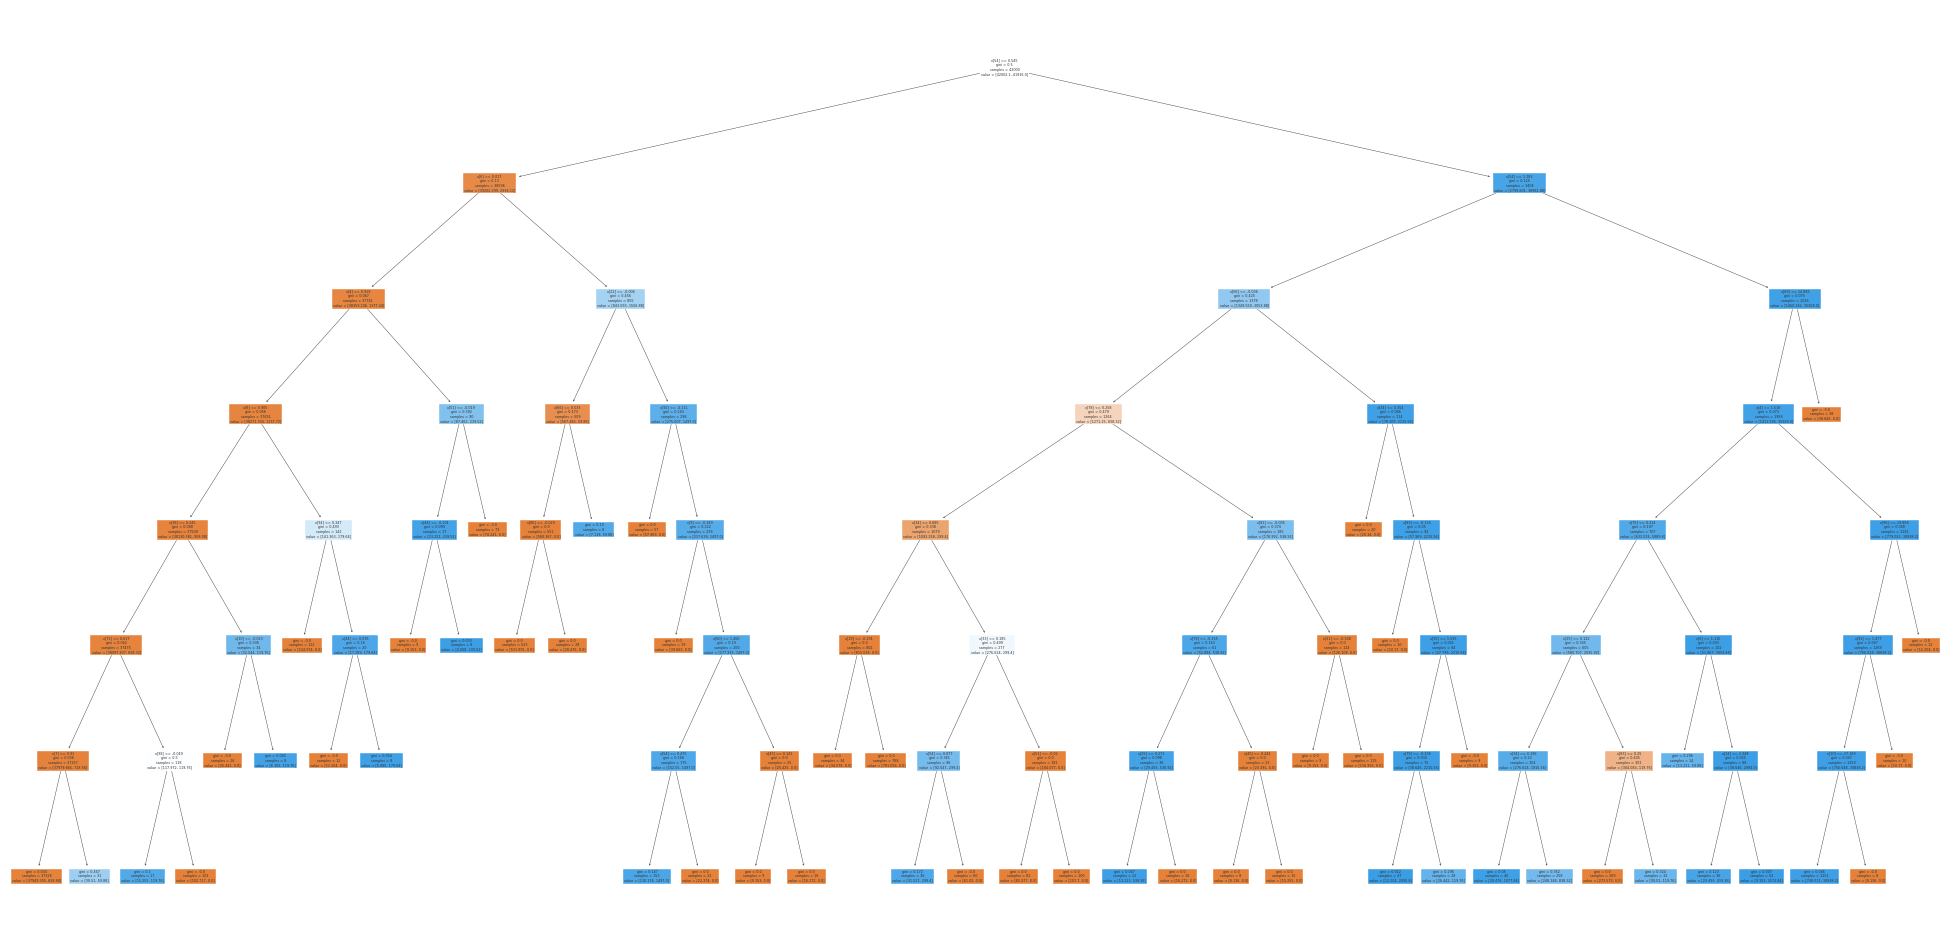

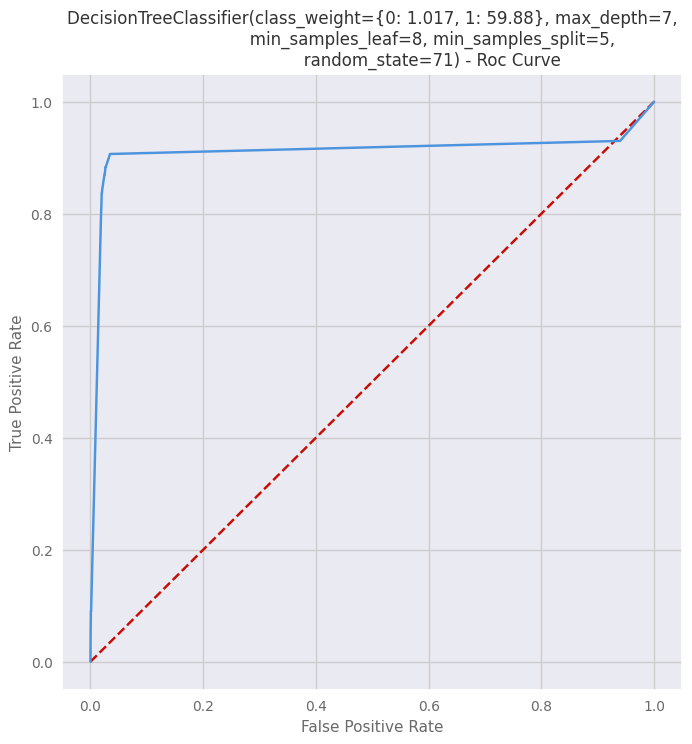

AUC Score (ROC): 0.9111101694915253

Stored Metrics
Completed Pipeline 



DecisionTreeClassifier(class_weight={0: 1.017, 1: 59.88}, max_depth=7,
                       min_samples_leaf=8, min_samples_split=5,
                       random_state=71)

In [89]:
# Decision Tree model

pipeline (tree, x_train, x_test, y_train, y_test)

bayes_search = BayesSearchCV(tree, tree_parameter_space, cv= 5, scoring= opt_metric, n_iter= 10, verbose= 0, random_state= 71)

bayes_search.fit(x_train, y_train)

# Saving a model with best estimators

best_tree = bayes_search.best_estimator_

# Pipeline again in the best tree model

pipeline (best_tree, x_train, x_test, y_train, y_test)

display(best_tree)

#### Random Forest

Applying Model
Evaluating Results
Test Sample Accuracy: 99.22222222222223

Test Sample Recall: 59.0

Sample Train Score (comparative): 1.0

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17700
           1       0.91      0.59      0.72       300

    accuracy                           0.99     18000
   macro avg       0.95      0.79      0.86     18000
weighted avg       0.99      0.99      0.99     18000



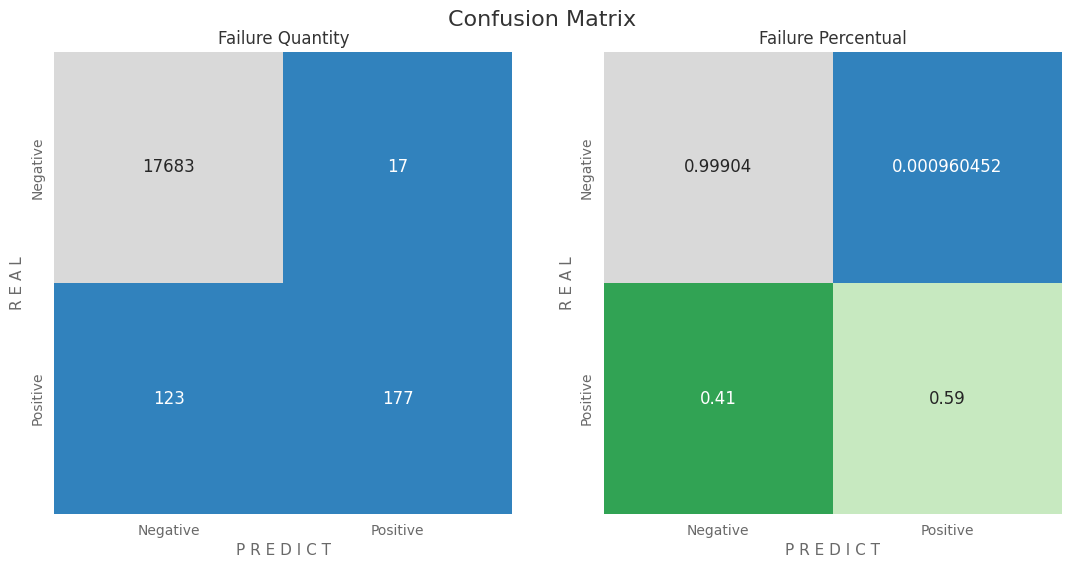

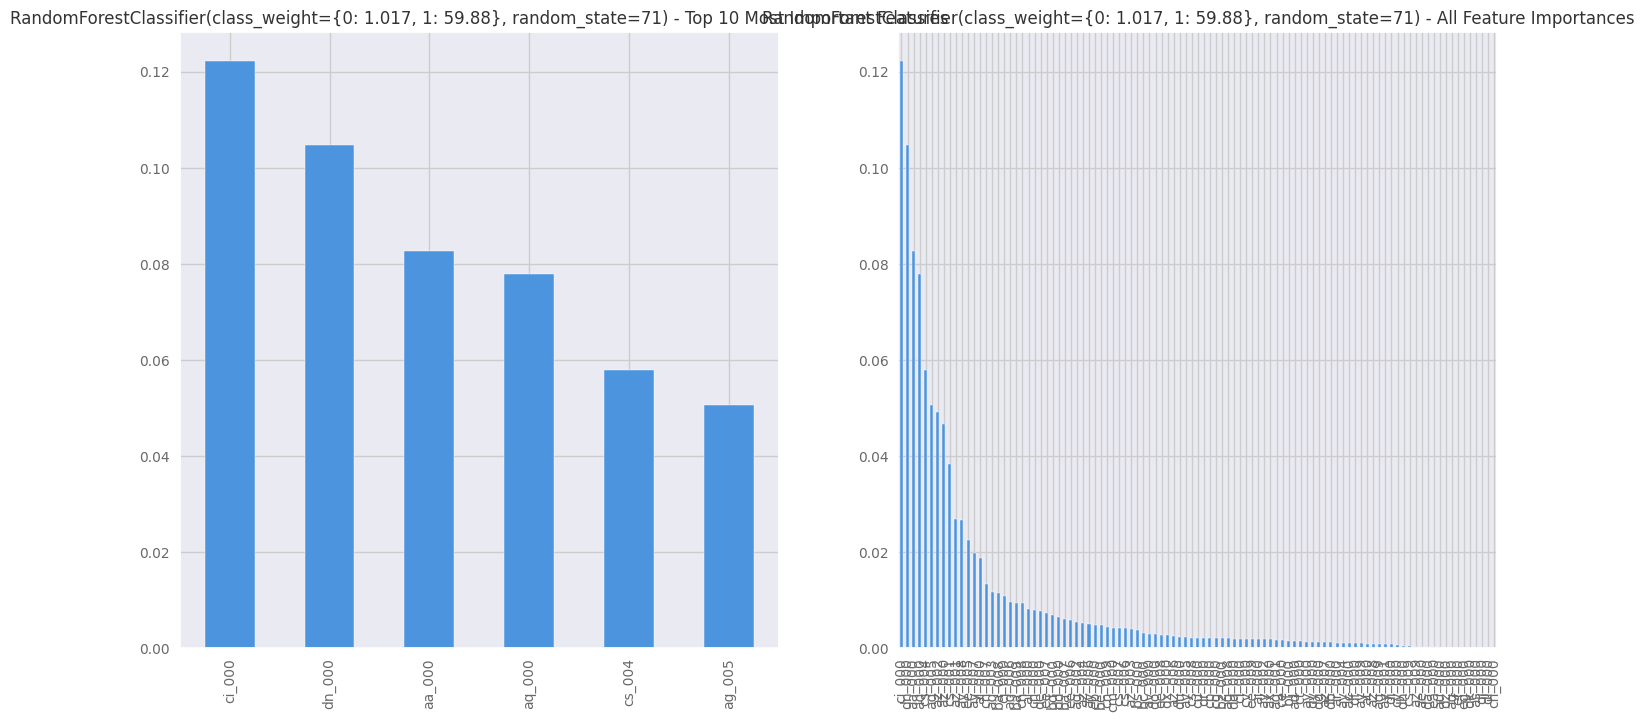

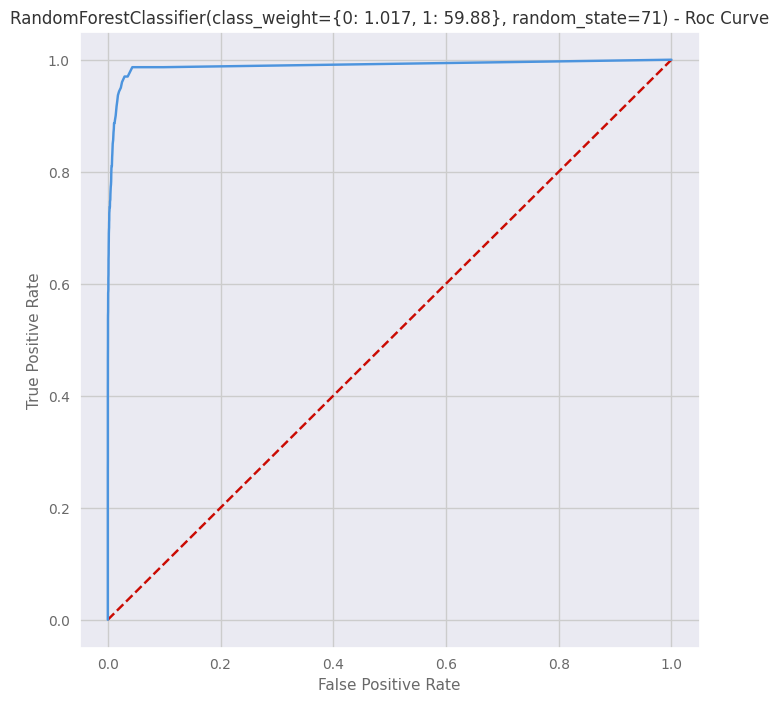

AUC Score (ROC): 0.9890942561205275

Stored Metrics
Completed Pipeline 

Applying Model
Evaluating Results
Test Sample Accuracy: 98.41111111111111

Test Sample Recall: 86.66666666666667

Sample Train Score (comparative): 0.9885238095238095

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17700
           1       0.51      0.87      0.65       300

    accuracy                           0.98     18000
   macro avg       0.76      0.93      0.82     18000
weighted avg       0.99      0.98      0.99     18000



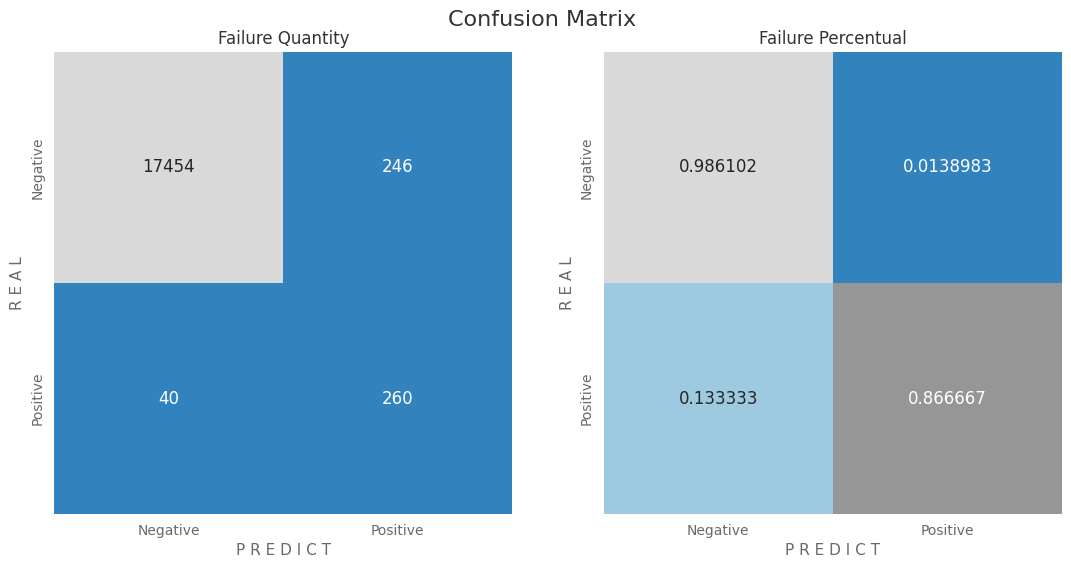

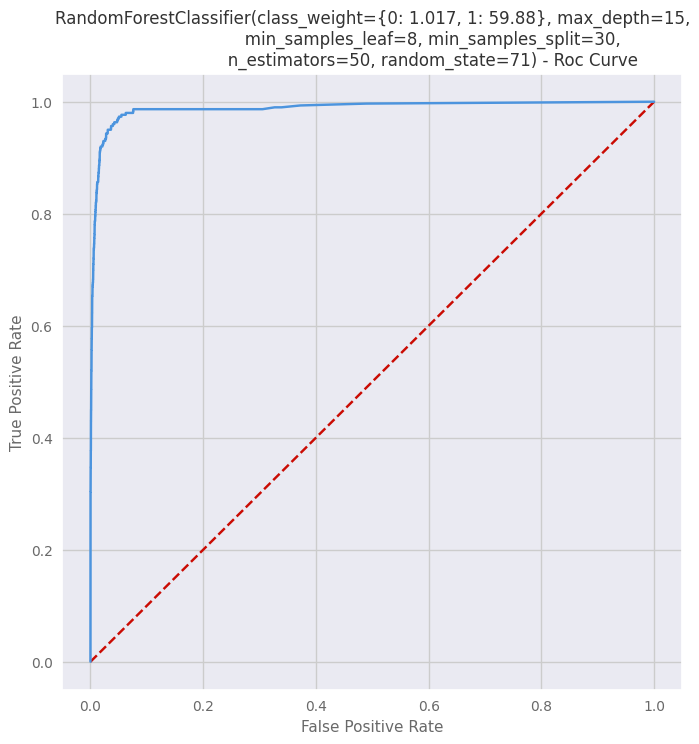

AUC Score (ROC): 0.9881827683615818

Stored Metrics
Completed Pipeline 



RandomForestClassifier(class_weight={0: 1.017, 1: 59.88}, max_depth=15,
                       min_samples_leaf=8, min_samples_split=30,
                       n_estimators=50, random_state=71)

In [90]:
# Random Forest model

pipeline (rf, x_train, x_test, y_train, y_test)

bayes_search = BayesSearchCV(rf, rf_parameter_space, cv= 5, scoring= opt_metric, n_iter= 10, verbose= 0, random_state= 71)

bayes_search.fit(x_train, y_train)

# Saving a model with best estimators

best_rf = bayes_search.best_estimator_

# Pipeline again in the best tree model

pipeline (best_rf, x_train, x_test, y_train, y_test)

display(best_rf)

#### Logistic Regression

Applying Model
Evaluating Results
Test Sample Accuracy: 97.58333333333333

Test Sample Recall: 89.33333333333333

Sample Train Score (comparative): 0.9760714285714286

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     17700
           1       0.40      0.89      0.55       300

    accuracy                           0.98     18000
   macro avg       0.70      0.94      0.77     18000
weighted avg       0.99      0.98      0.98     18000



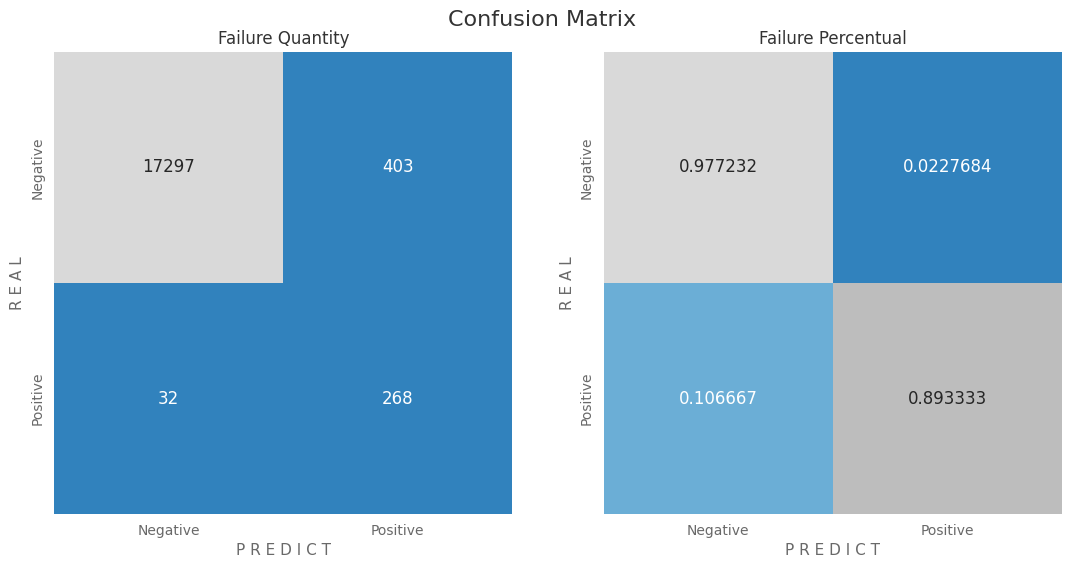

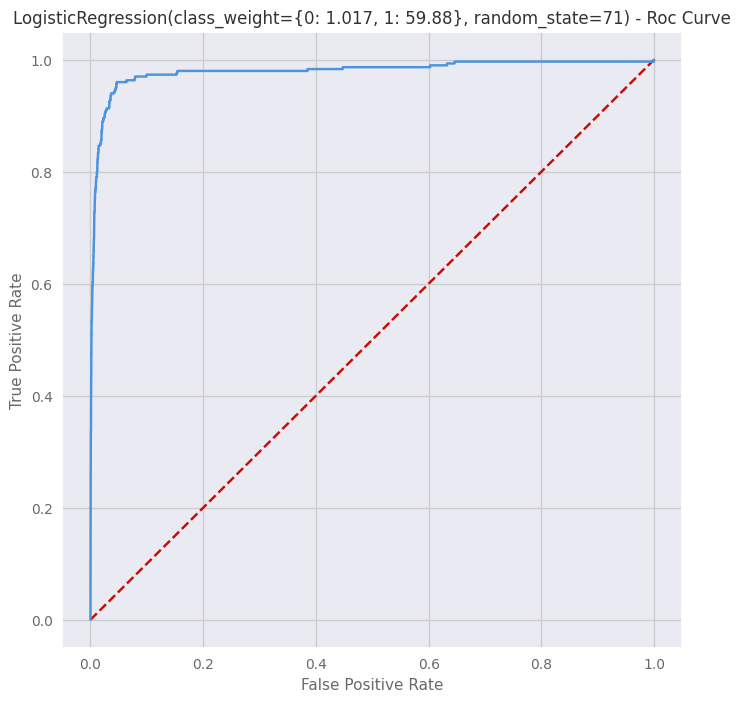

AUC Score (ROC): 0.9797047080979284

Stored Metrics
Completed Pipeline 

Applying Model
Evaluating Results
Test Sample Accuracy: 97.54444444444445

Test Sample Recall: 90.33333333333333

Sample Train Score (comparative): 0.9755238095238096

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     17700
           1       0.40      0.90      0.55       300

    accuracy                           0.98     18000
   macro avg       0.70      0.94      0.77     18000
weighted avg       0.99      0.98      0.98     18000



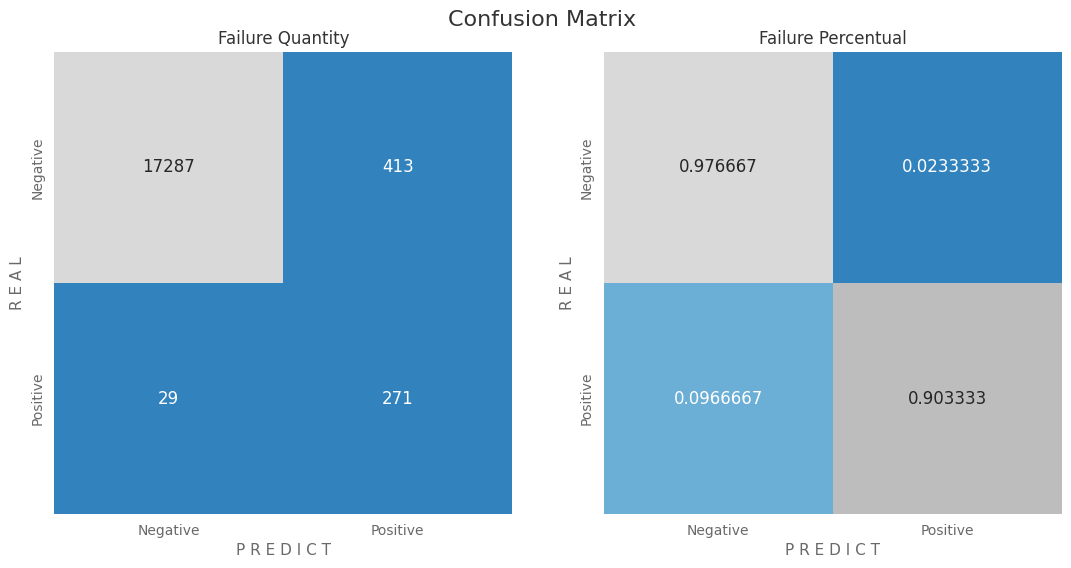

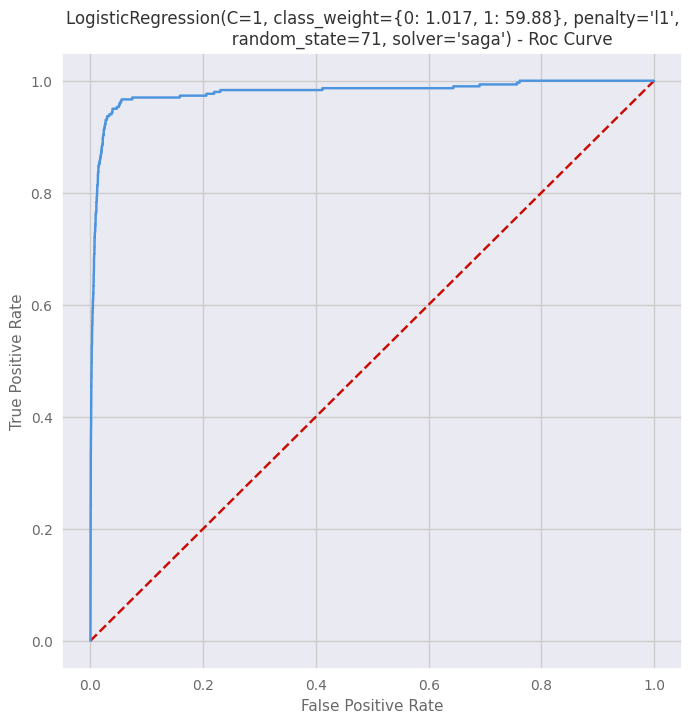

AUC Score (ROC): 0.980122504708098

Stored Metrics
Completed Pipeline 



LogisticRegression(C=1, class_weight={0: 1.017, 1: 59.88}, penalty='l1',
                   random_state=71, solver='saga')

In [91]:
# Logistic Regression model

pipeline (log_reg, x_train, x_test, y_train, y_test)

bayes_search = BayesSearchCV(log_reg, log_reg_parameter_space, cv= 5, scoring= opt_metric, n_iter= 10, verbose= 0, random_state= 71)

bayes_search.fit(x_train, y_train)

# Saving a model with best estimators

best_log_reg = bayes_search.best_estimator_

# Pipeline again in the best tree model

pipeline (best_log_reg, x_train, x_test, y_train, y_test)

display(best_log_reg)

#### XGBoost Model

Applying Model
Evaluating Results
Test Sample Accuracy: 99.32222222222222

Test Sample Recall: 81.33333333333333

Sample Train Score (comparative): 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17700
           1       0.79      0.81      0.80       300

    accuracy                           0.99     18000
   macro avg       0.89      0.90      0.90     18000
weighted avg       0.99      0.99      0.99     18000



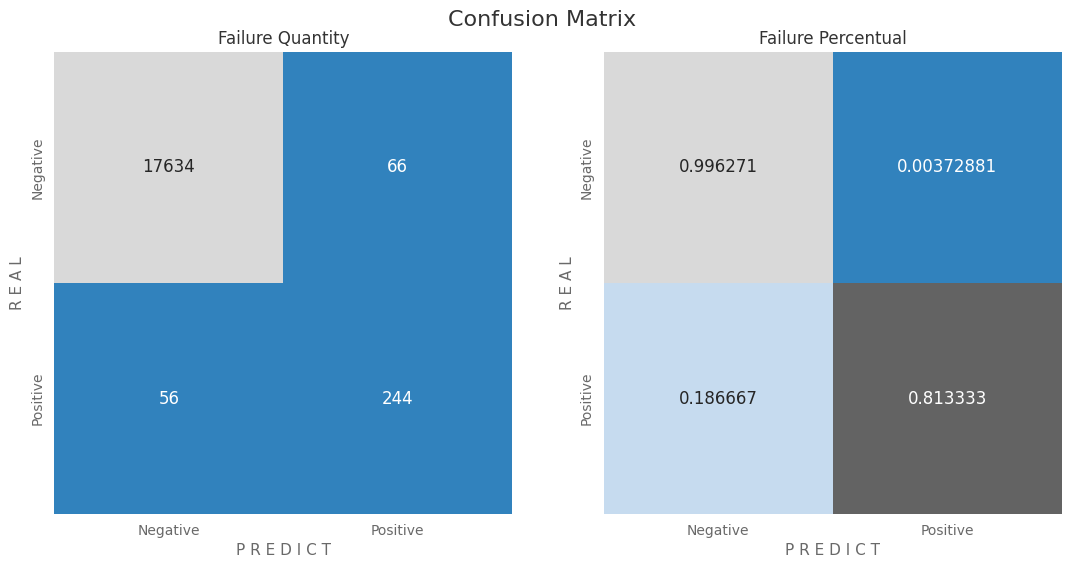

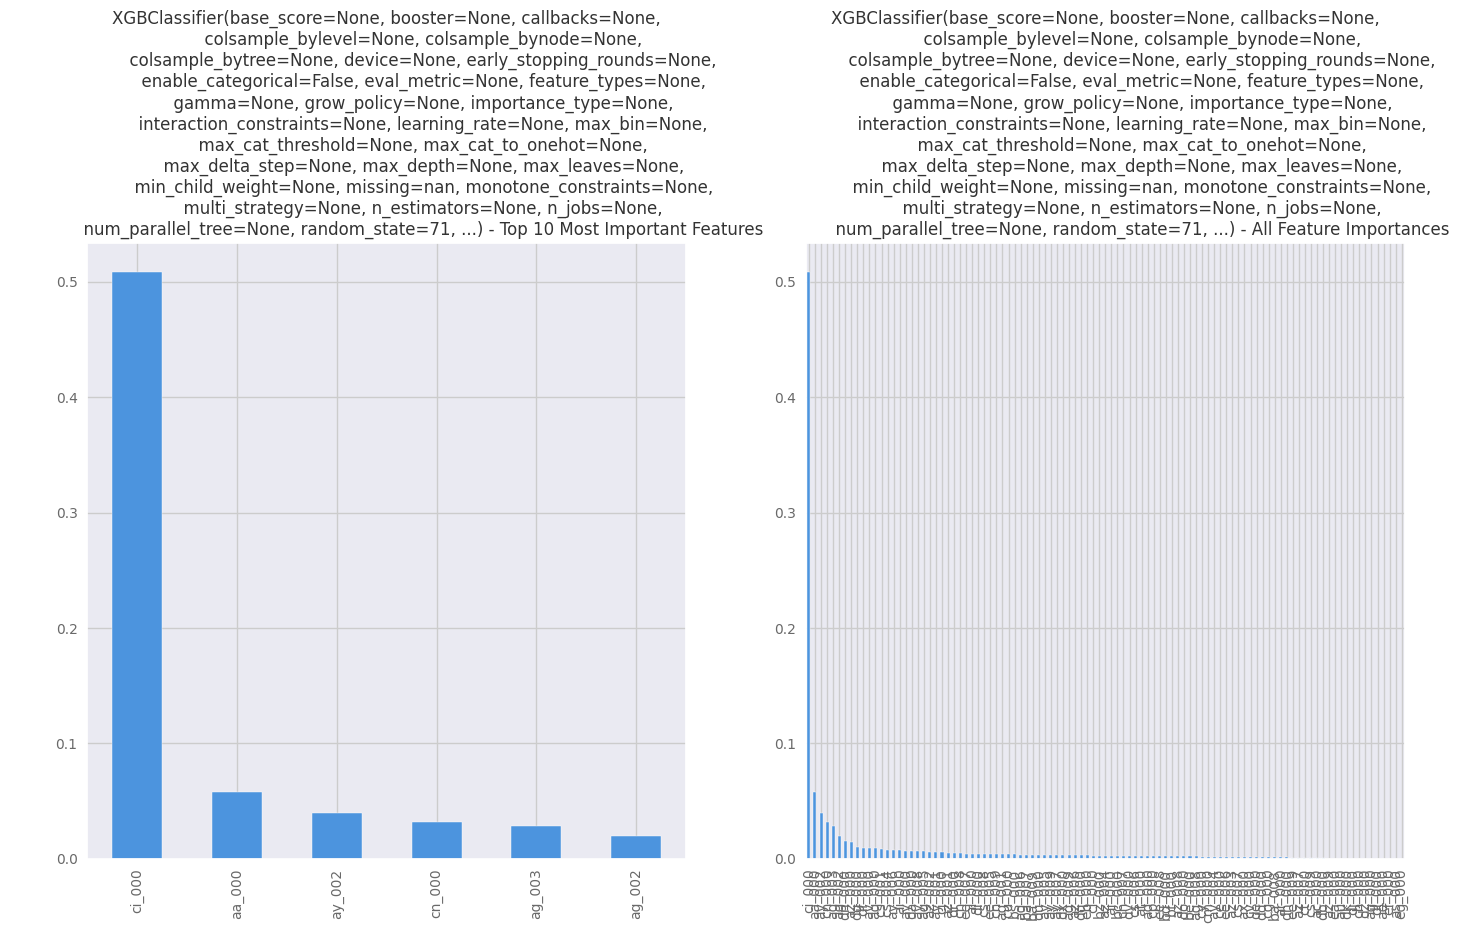

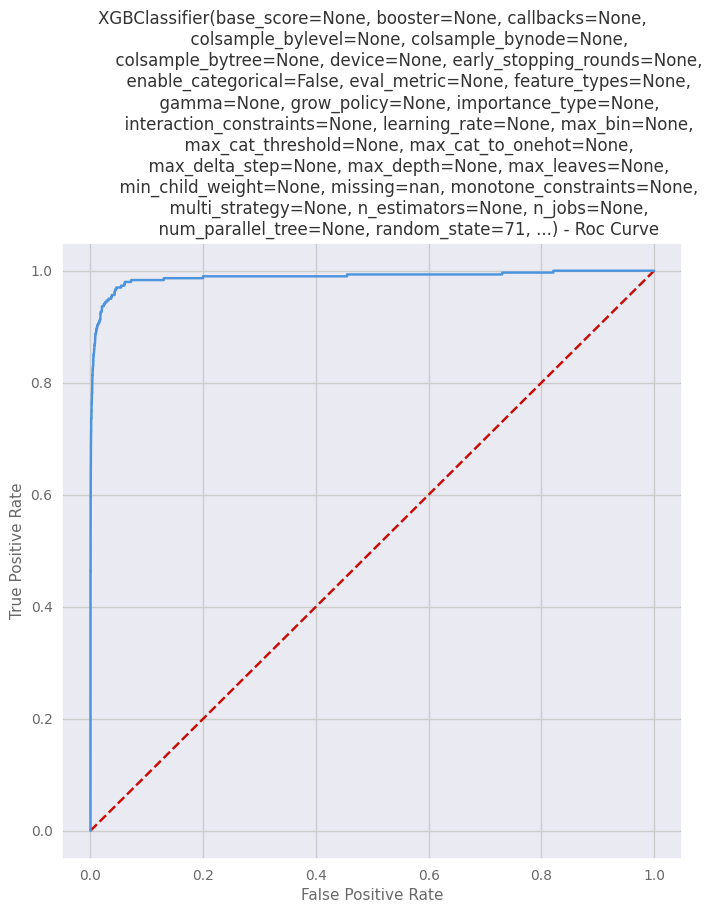

AUC Score (ROC): 0.9885996233521657

Stored Metrics
Completed Pipeline 

Applying Model
Evaluating Results
Test Sample Accuracy: 99.11666666666666

Test Sample Recall: 81.0

Sample Train Score (comparative): 0.9990238095238095

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     17700
           1       0.70      0.81      0.75       300

    accuracy                           0.99     18000
   macro avg       0.85      0.90      0.87     18000
weighted avg       0.99      0.99      0.99     18000



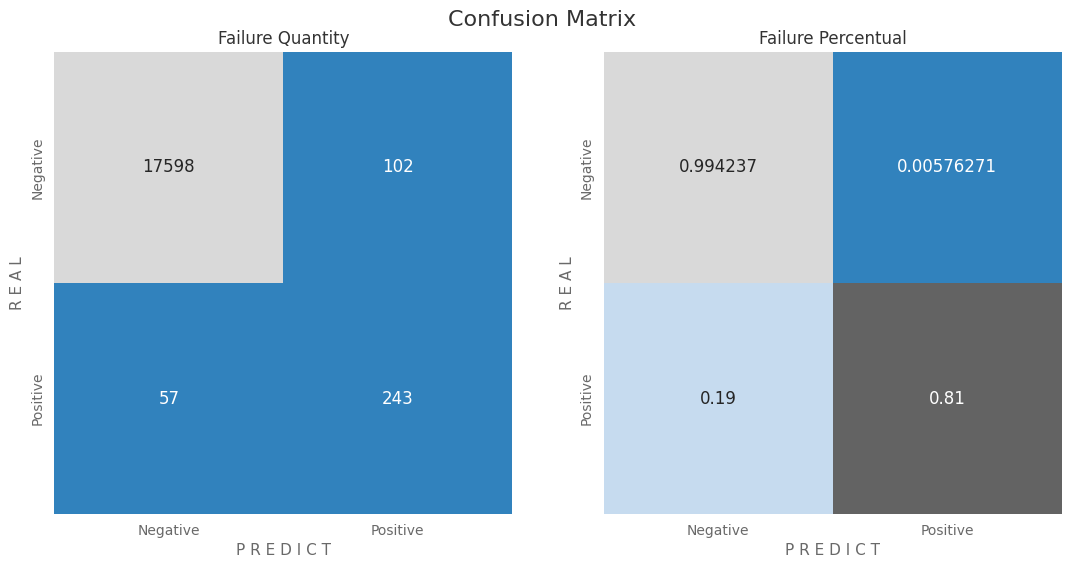

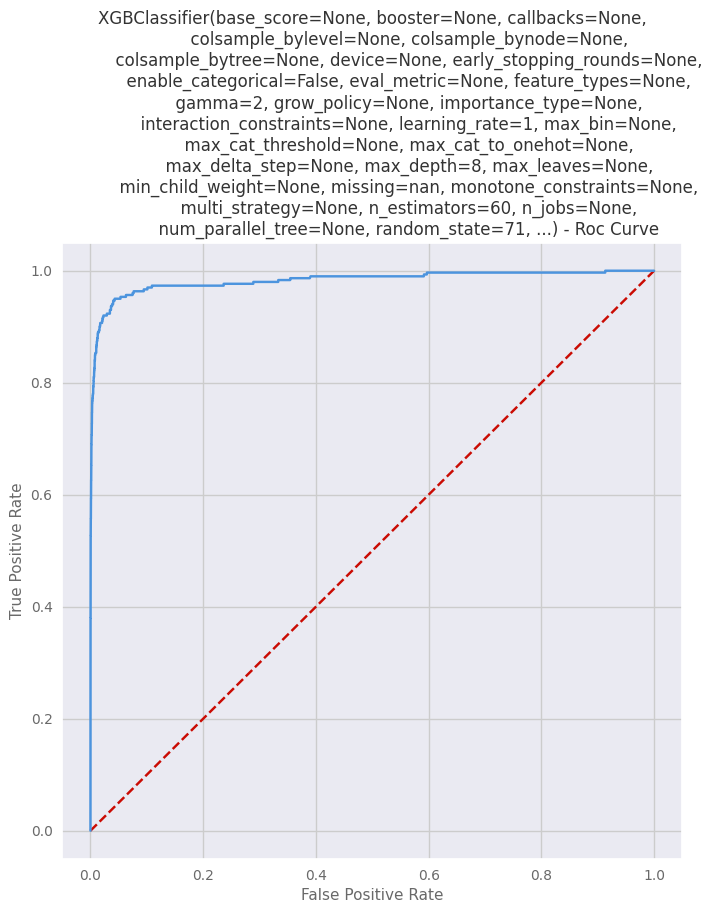

AUC Score (ROC): 0.9827094161958569

Stored Metrics
Completed Pipeline 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=71, ...)


In [92]:
# XG Boost model

pipeline (xgboostclassifier, x_train, x_test, y_train, y_test)

bayes_search = BayesSearchCV(xgboostclassifier, xgboost_parameter, cv= 5, scoring= opt_metric, n_iter= 10, verbose= 0, random_state= 71)

bayes_search.fit(x_train, y_train)

# Saving a model with best estimators

best_xgboost = bayes_search.best_estimator_

# Pipeline again in the best XG boost model

pipeline (best_xgboost, x_train, x_test, y_train, y_test)

print(best_xgboost)

#### LGBM Model

Applying Model
[LightGBM] [Info] Number of positive: 700, number of negative: 41300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21458
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499487 -> initscore=-0.002052
[LightGBM] [Info] Start training from score -0.002052
Evaluating Results
Test Sample Accuracy: 99.01666666666667

Test Sample Recall: 84.66666666666667

Sample Train Score (comparative): 0.9980476190476191

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17700
           1       0.66      0.85      0.74       300

    accuracy                           0.99     18000
   macro avg       0.83      0.92      0.87     18000
wei

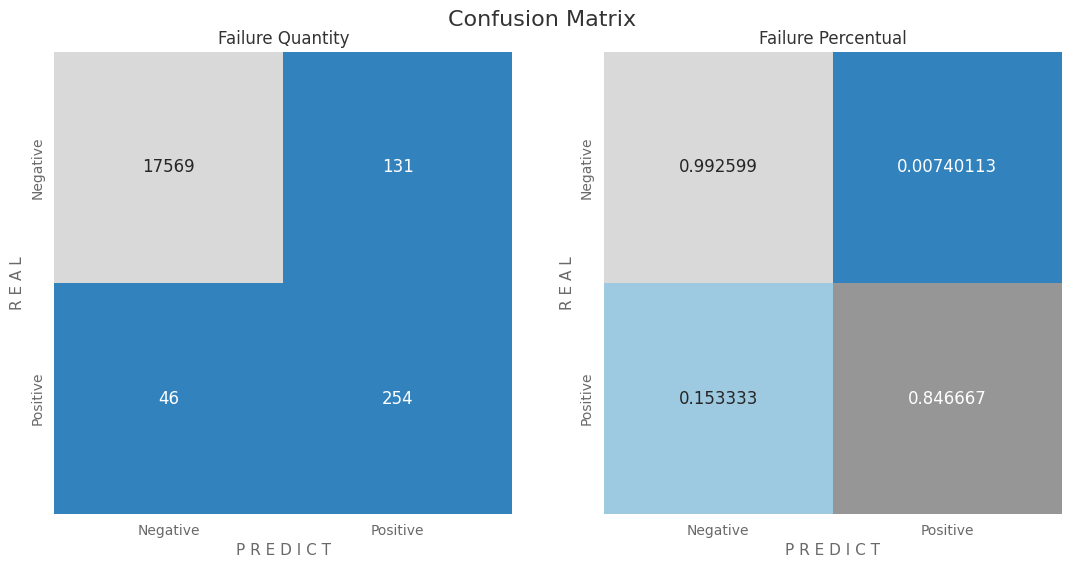

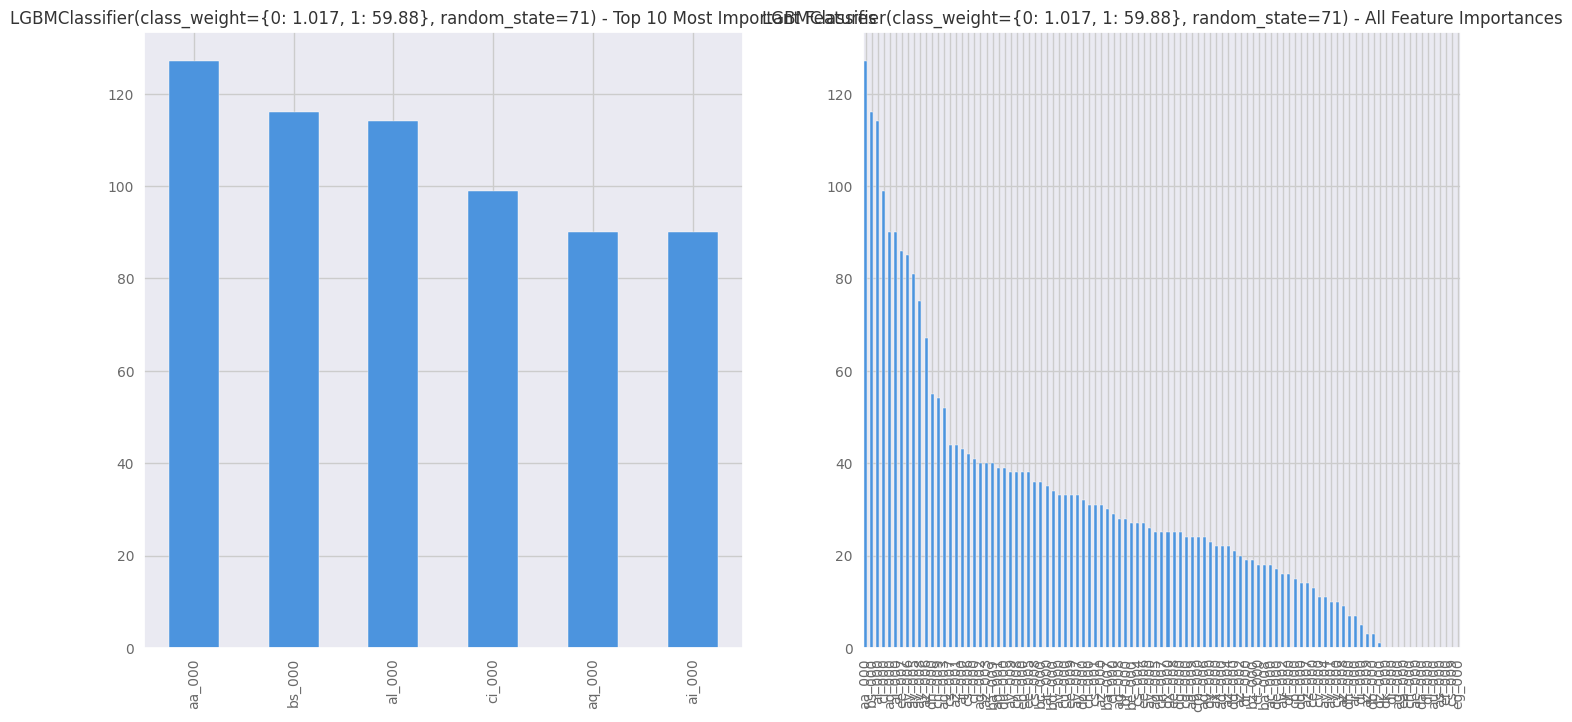

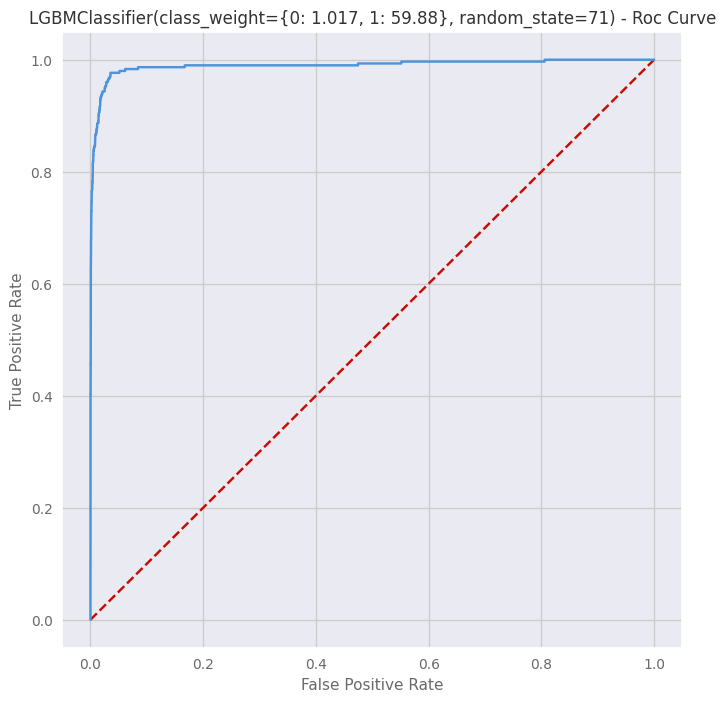

AUC Score (ROC): 0.9896790960451978

Stored Metrics
Completed Pipeline 

Applying Model
Evaluating Results
Test Sample Accuracy: 99.01666666666667

Test Sample Recall: 84.66666666666667

Sample Train Score (comparative): 0.9980476190476191

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17700
           1       0.66      0.85      0.74       300

    accuracy                           0.99     18000
   macro avg       0.83      0.92      0.87     18000
weighted avg       0.99      0.99      0.99     18000



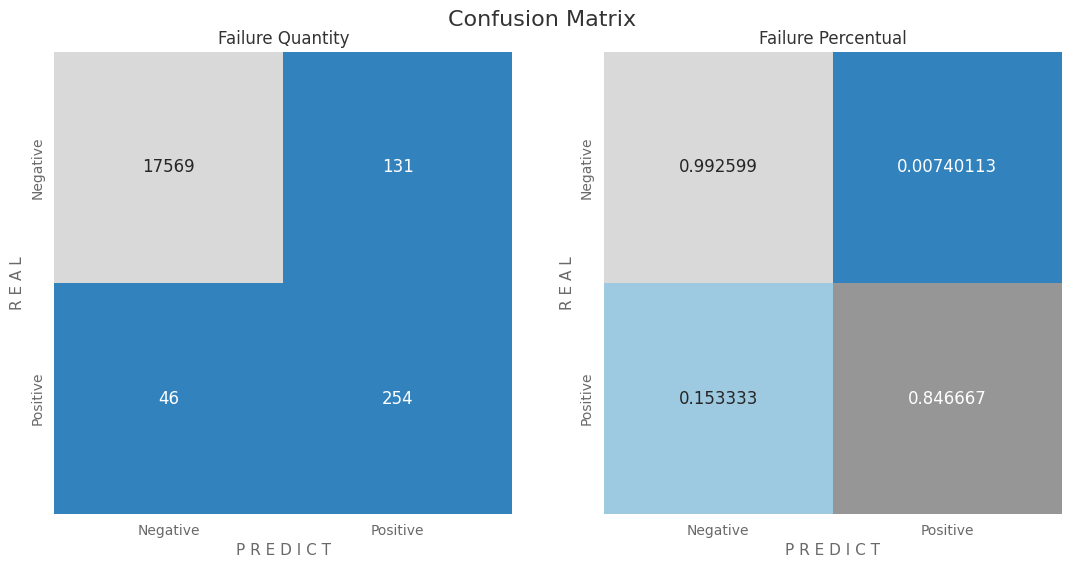

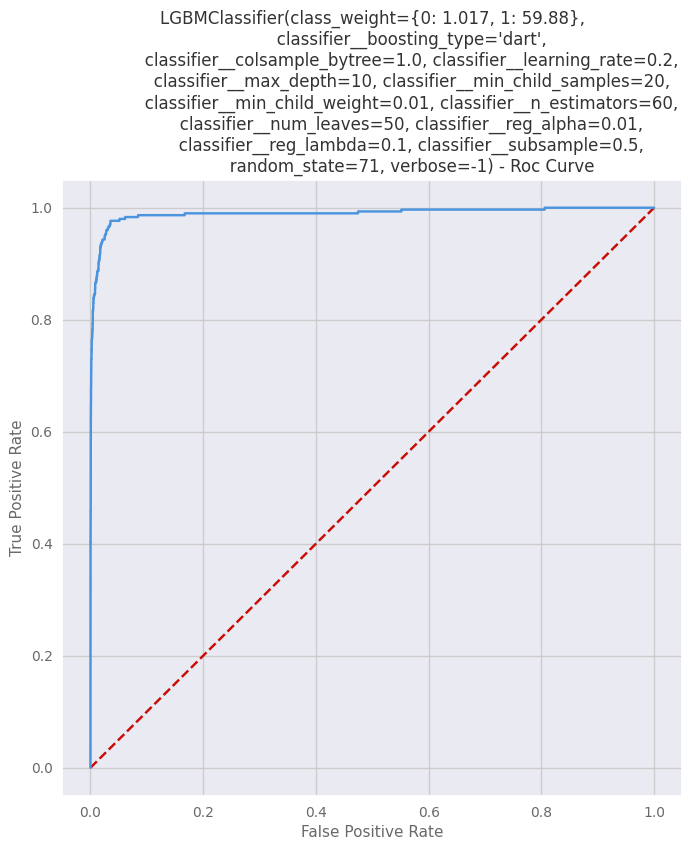

AUC Score (ROC): 0.9896790960451978

Stored Metrics
Completed Pipeline 

LGBMClassifier(class_weight={0: 1.017, 1: 59.88},
               classifier__boosting_type='dart',
               classifier__colsample_bytree=1.0, classifier__learning_rate=0.2,
               classifier__max_depth=10, classifier__min_child_samples=20,
               classifier__min_child_weight=0.01, classifier__n_estimators=60,
               classifier__num_leaves=50, classifier__reg_alpha=0.01,
               classifier__reg_lambda=0.1, classifier__subsample=0.5,
               random_state=71, verbose=-1)


In [93]:
# LGBM model

pipeline (lgbm, x_train, x_test, y_train, y_test)

bayes_search = BayesSearchCV(lgbm, lgbm_parameter_space, cv= 5, scoring= opt_metric, n_iter= 10, verbose= 0, random_state= 71)

bayes_search.fit(x_train, y_train)

# Saving a model with best estimators

best_lgbm = bayes_search.best_estimator_

# Pipeline again in the best LGBM model

pipeline (best_lgbm, x_train, x_test, y_train, y_test)

print(best_lgbm)


### Evaluating models

In [94]:
# Compare all the stored metrics in the empty lists created above

# Create a DataFrame with the stored metrics
results_df = pd.DataFrame({
    'Model': model_name,
    'Precision': precision,
    'Accuracy': accuracy,
    'Recall': recall,
    'ROC AUC': roc_curve_sco,
    'F1 Score': f1_sco,
    # 'Log Loss': log_loss
})

# Display the DataFrame
display(results_df)


Model  Precision   Accuracy     Recall    ROC AUC  \
0  DecisionTreeClassifier  25.428314  95.305556  94.000000  94.357062   
1  DecisionTreeClassifier  30.804077  96.450000  90.666667  91.111017   
2  RandomForestClassifier  91.237113  99.222222  59.000000  98.909426   
3  RandomForestClassifier  51.383399  98.411111  86.666667  98.818277   
4      LogisticRegression  39.940387  97.583333  89.333333  97.970471   
5      LogisticRegression  39.619883  97.544444  90.333333  98.012250   
6           XGBClassifier  78.709677  99.322222  81.333333  98.859962   
7           XGBClassifier  70.434783  99.116667  81.000000  98.270942   
8          LGBMClassifier  65.974026  99.016667  84.666667  98.967910   
9          LGBMClassifier  65.974026  99.016667  84.666667  98.967910   

    F1 Score  
0  40.028389  
1  45.984784  
2  71.659919  
3  64.516129  
4  55.200824  
5  55.081301  
6  80.000000  
7  75.348837  
8  74.160584  
9  74.160584

 * This is a classification case where the most expensive is False Negative costs. So recall is the main metrics to be condsidered.

 * But this case has also a False Positive cost, so a balance between Recall and Precision metrics should be considered to decide which one is the best model.

 * Considering all metrics and models above, XGBoost was the best performance because of the balance between recall, precision and F1-score.

 * XGBoost also presents a good balance between False Positives and False Negatives.


In [95]:
# Apply scaler and imputer in df to make predictions based on trained model

df_prediction = df_prev_selected.copy()
df = df_prediction.drop(columns= ['class'])

imputer = SimpleImputer(missing_values= np.nan, strategy= 'median')
df_prediction = pd.DataFrame(imputer.fit_transform(df), columns= df.columns)

scaler = StandardScaler()
df_prediction = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)

df_prediction

dy_000    cs_006    cl_000    ea_000    aq_000    ag_008    ag_003  \
0     -0.131327  0.299152 -0.071604 -0.029288  0.546264 -0.043942 -0.116304   
1     -0.131327 -0.209326 -0.072879 -0.029288 -0.082268 -0.017842 -0.116304   
2     -0.131327 -0.049198 -0.072879 -0.029288 -0.228686 -0.106990 -0.116304   
3     -0.130585 -0.466865 -0.072454 -0.029288 -0.349628 -0.161571 -0.115886   
4      0.334340  0.506334 -0.072879 -0.029288  0.086037 -0.140731 -0.116304   
...         ...       ...       ...       ...       ...       ...       ...   
59995 -0.131327  1.441931 -0.051208 -0.029288  0.264536  0.587789 -0.112937   
59996 -0.130990 -0.402330 -0.072879 -0.029288 -0.341225 -0.161571 -0.116304   
59997 -0.131327 -0.465680 -0.068205 -0.029288 -0.349739 -0.161571 -0.116304   
59998 -0.131327  0.656606 -0.072879 -0.029288  0.611953  1.475655 -0.116304   
59999 -0.131327 -0.267479 -0.072879 -0.029288 -0.085183  0.118892 -0.116304   

         aa_000    cj_000    az_004  ...    ee_007    az_002    da_000  \
0      0.119381 -0.090596 -0.205936  ... -0.108976 -0.037074 -0.038815   
1     -0.180697 -0.090596 -0.111572  ... -0.153429  0.053565       NaN   
2     -0.125811 -0.090596  0.079996  ... -0.108938 -0.064148 -0.038815   
3     -0.407928 -0.090596 -0.352964  ... -0.200384 -0.075611 -0.038815   
4      0.010572 -0.090596 -0.345766  ... -0.020087 -0.070396 -0.038815   
...         ...       ...       ...  ...       ...       ...       ...   
59995  0.644064 -0.090596 -0.338604  ...  0.214978 -0.033397 -0.038815   
59996 -0.392291 -0.090596 -0.352916  ... -0.200384 -0.075405 -0.038815   
59997 -0.407240 -0.086878 -0.352762  ... -0.198866 -0.067075 -0.038815   
59998  0.144095  0.002787 -0.128230  ... -0.104859 -0.033134 -0.038815   
59999 -0.131435 -0.090596  0.152741  ... -0.108775 -0.041390 -0.038815   

         eb_000    bs_000    ba_009   dj_000    cg_000    ch_000    az_003  
0     -0.161790  1.161721 -0.106663 -0.00881  0.012052 -0.014886 -0.114646  
1     -0.145960 -0.871598 -0.092623 -0.00881       NaN       NaN -0.113517  
2     -0.202987 -0.619563 -0.106663 -0.00881  0.087382 -0.014886 -0.081119  
3     -0.227320 -0.825688 -0.106663 -0.00881 -0.230081 -0.014886 -0.132150  
4      0.267998  1.285491 -0.106663 -0.00881  0.162712 -0.014886 -0.132260  
...         ...       ...       ...      ...       ...       ...       ...  
59995  1.647116  1.982196 -0.106663 -0.00881 -0.020233 -0.014886 -0.122120  
59996 -0.197236 -0.670207 -0.106663 -0.00881 -0.235462 -0.014886 -0.133497  
59997 -0.227320 -0.791846 -0.106556 -0.00881 -0.246223 -0.014886 -0.127517  
59998  0.705655 -0.726767 -0.106663 -0.00881  0.082001 -0.014886 -0.117555  
59999  0.690210  0.318528 -0.106663 -0.00881  0.076621 -0.014886  0.202319  

[60000 rows x 99 columns]

In [96]:
# Access score predictions of classification lgbm model and store in a new column

#df_prediction.drop(columns= ['score_prediction', 'class_prediction'], inplace= True)


df_prediction['score_prediction'] = best_xgboost.predict_proba(df_prediction)[:, 1] * 100

df_prediction['score_prediction'].sort_values(ascending= False)

40558    99.995445
45476    99.995316
2520     99.995270
18760    99.994698
5464     99.994041
           ...    
3721      0.000108
42600     0.000097
9885      0.000077
40238     0.000067
43124     0.000042
Name: score_prediction, Length: 60000, dtype: float32

In [97]:
# Access class predictions and store in a new column at 50% threshold

df_prediction['class_prediction'] = best_xgboost.predict(X)

df_prediction['class_prediction'].value_counts()

class_prediction
0    44862
1    15138
Name: count, dtype: int64

In [98]:
# Create a comparative analysis of the best threshold limit for classification using recall and f1-score

def find_best_threshold(y_true, y_pred_prob):

  best_threshold = 0
  best_score = 0

  for threshold in np.arange(0, 100, 1):
    y_pred = (y_pred_prob >= threshold).astype(int)
    score = f1_score(y_true, y_pred)

    if score > best_score:
      best_score = score
      best_threshold = threshold

  return best_threshold, best_score

# Get predicted probabilities for the test set
y_pred_prob = best_xgboost.predict_proba(x_test)[:, 1] * 100

# Find the best threshold for F1-score
best_threshold_f1, best_f1_score = find_best_threshold(y_test, y_pred_prob)
print(f"Best threshold for F1-score: {best_threshold_f1:.2f}, Best F1-score: {best_f1_score:.2f}")

# Create a DataFrame to compare the thresholds and scores
threshold_comparison = pd.DataFrame({
    'Metric': [ 'F1-score'],
    'Best Threshold': [ best_threshold_f1],
    'Best Score': [ best_f1_score]
})

print("\nBest Threshold:")
display(threshold_comparison)


Best threshold for F1-score: 82.00, Best F1-score: 0.79

Best Threshold:


Metric  Best Threshold  Best Score
0  F1-score              82    0.786942

In [99]:
# Create a DataFrame to store the results

threshold_df = pd.DataFrame(columns=['Threshold', 'Precision', 'Recall', 'F1 Score'])

# Evaluate the model with different thresholds
for threshold in np.arange(0, 101, 1):
  y_pred = (y_pred_prob > threshold).astype(int)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  threshold_df = pd.concat([threshold_df, pd.DataFrame({'Threshold': [threshold], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]})], ignore_index=True)

# Display the results
display(threshold_df)

Threshold  Precision    Recall  F1 Score
0           0   0.016667  1.000000  0.032787
1           1   0.352490  0.920000  0.509695
2           2   0.408618  0.916667  0.565262
3           3   0.446634  0.906667  0.598460
4           4   0.472855  0.900000  0.619977
..        ...        ...       ...       ...
96         96   0.875536  0.680000  0.765478
97         97   0.879310  0.680000  0.766917
98         98   0.889401  0.643333  0.746615
99         99   0.920635  0.580000  0.711656
100       100   0.000000  0.000000  0.000000

[101 rows x 4 columns]

In [101]:
# Show the results between Threshold

display(threshold_df[(threshold_df['Threshold'] >= best_threshold_f1 - 2) & (threshold_df['Threshold'] <= best_threshold_f1 + 2)])


Threshold  Precision    Recall  F1 Score
80        80   0.807018  0.766667  0.786325
81        81   0.809187  0.763333  0.785592
82        82   0.812057  0.763333  0.786942
83        83   0.810036  0.753333  0.780656
84        84   0.812950  0.753333  0.782007

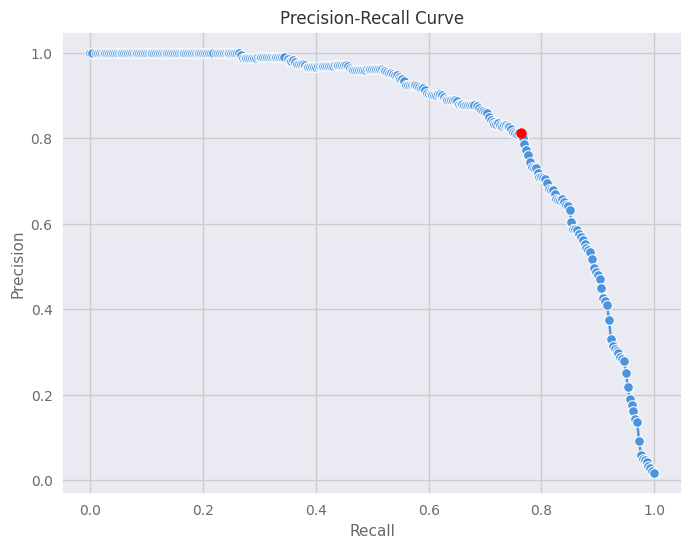

AUC of Precision-Recall Curve: 0.8409038961965379


In [104]:
# Plot a chart with recall precision curve

# Get the predicted probabilities for the test set
y_pred_prob = best_xgboost.predict_proba(x_test)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure(figsize= (8, 6))
sns.lineplot(x= recall, y= precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Highlight the point with the best threshold using a red dot
plt.scatter(threshold_df.loc[threshold_df['Threshold'] == best_threshold_f1, 'Recall'].values,
            threshold_df.loc[threshold_df['Threshold'] == best_threshold_f1, 'Precision'].values,
            color= 'red', s= 50, zorder= 2)

plt.show()

# Calculate the AUC of the precision-recall curve
auc_pr = auc(recall, precision)

print(f"AUC of Precision-Recall Curve: {auc_pr}")


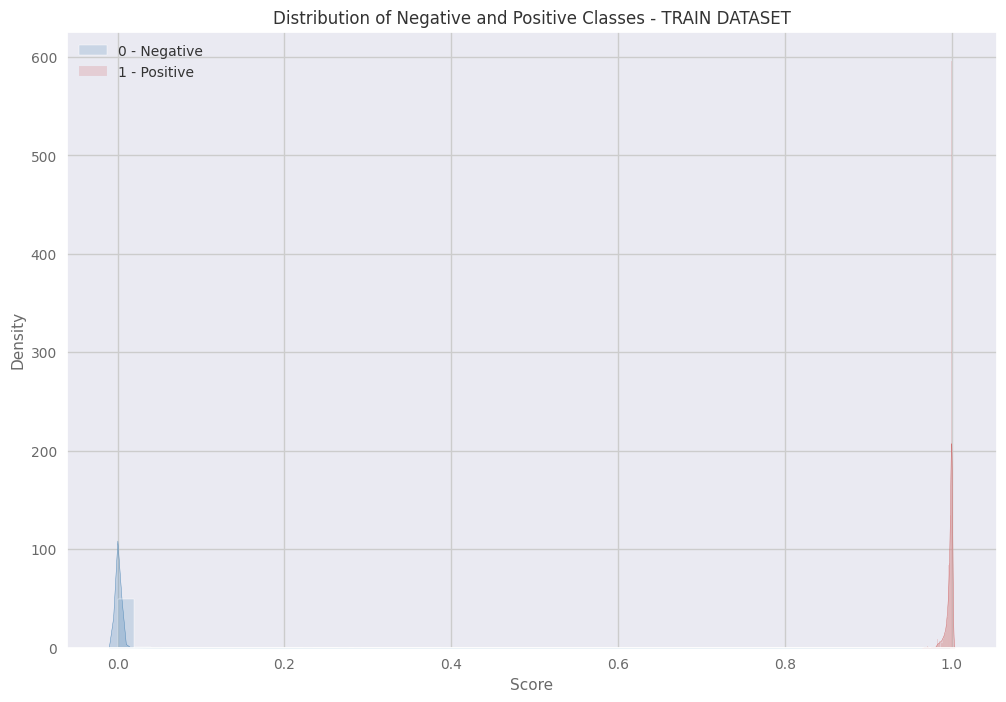

In [105]:
# Plot negative and positive cases distribution by threshold in TRAIN DATA

model = best_xgboost.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_train_pred_prob = model.predict_proba(x_train)[:,1]

df_lgbm = pd. DataFrame({'target': y_train, 'predict': y_train_pred_prob})

negative = df_lgbm.loc[df_lgbm['target'] == 0]
positive = df_lgbm.loc[df_lgbm['target'] == 1]

fig, ax = plt.subplots(figsize= (12, 8))

sns.kdeplot(negative.predict, ax= ax, fill= True, color= 'steelblue')
sns.histplot(negative.predict, ax= ax, bins= 50, stat= 'density', color= 'steelblue',
             alpha= 0.2, label= '0 - Negative', cbar_kws= {'linewidth': 0.1})

sns.kdeplot(positive.predict, ax= ax, fill= True, color= 'indianred')
sns.histplot(positive.predict, ax= ax, bins= 50, stat= 'density', color= 'indianred',
             alpha= 0.2, label= '1 - Positive', cbar_kws= {'linewidth': 0.1})

ax.set_title('Distribution of Negative and Positive Classes - TRAIN DATASET')
ax.set_xlabel('Score')
ax.set_ylabel('Density')
ax.legend()

plt.show()


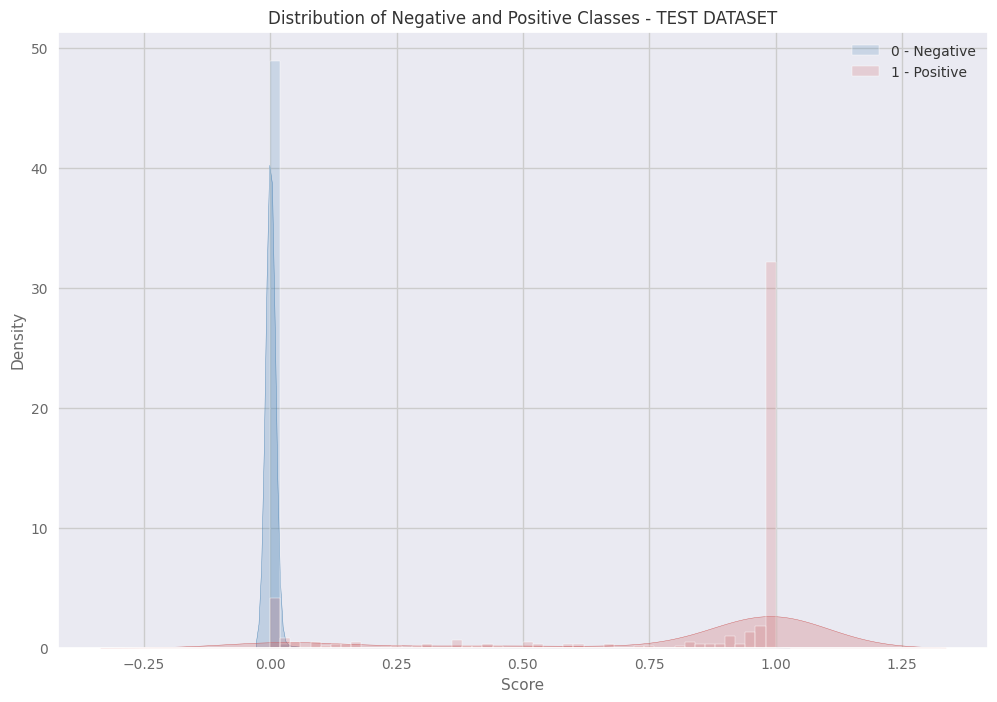

In [106]:
# Plot negative and positive cases distribution by threshold in TEST DATA

model = best_xgboost.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred_prob = model.predict_proba(x_test)[:,1]

df_lgbm = pd. DataFrame({'target': y_test, 'predict': y_test_pred_prob})

negative = df_lgbm.loc[df_lgbm['target'] == 0]
positive = df_lgbm.loc[df_lgbm['target'] == 1]

fig, ax = plt.subplots(figsize= (12, 8))

sns.kdeplot(negative.predict, ax= ax, fill= True, color= 'steelblue')
sns.histplot(negative.predict, ax= ax, bins= 50, stat= 'density', color= 'steelblue',
             alpha= 0.2, label= '0 - Negative', cbar_kws= {'linewidth': 0.1})

sns.kdeplot(positive.predict, ax= ax, fill= True, color= 'indianred')
sns.histplot(positive.predict, ax= ax, bins= 50, stat= 'density', color= 'indianred',
             alpha= 0.2, label= '1 - Positive', cbar_kws= {'linewidth': 0.1})

ax.set_title('Distribution of Negative and Positive Classes - TEST DATASET')
ax.set_xlabel('Score')
ax.set_ylabel('Density')
ax.legend()

plt.show()

In [107]:
# Calculate best threshold for classification model using TP, TN, FP, FN and the charges associated to each category

y_true = df_prev_selected['class']
y_pred_prob = best_xgboost.predict_proba(X)[:, 1] * 100
cost_fp = 10
cost_fn = 500
cost_tp = 25

# Define empty lists
threshold_list = []
# Lists for number of cases
TP_cases = []
FP_cases = []
FN_cases = []
TN_cases = []
# Lists for total costs
Total_costs = []
Regular_costs = []
FP_costs = []
TP_costs = []
FN_costs =[]


def calculate_best_threshold(y_true, y_pred_prob, cost_fp, cost_fn, cost_tp):

  best_threshold = 0
  min_cost = float('inf')

  for threshold in np.arange(1, 99, 1):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FN_cost = cost_fn * fn
    TP_cost = cost_tp * tp
    FP_cost = cost_fp * fp

    regular_cost = TP_cost + FP_cost
    cost = FN_cost + TP_cost + FP_cost

    if cost < min_cost:
    #if FN_cost < regular_cost < min_cost :
      min_cost = cost
      best_threshold = threshold

    # Store results
    TP_costs.append(TP_cost)
    FN_costs.append(FN_cost)
    FP_costs.append(FP_cost)
    Total_costs.append(cost)
    Regular_costs.append(regular_cost)
    TP_cases.append(tp)
    FP_cases.append(fp)
    FN_cases.append(fn)
    TN_cases.append(tn)
    threshold_list.append(threshold)

  return best_threshold

best_threshold = calculate_best_threshold(y_true, y_pred_prob, cost_fp, cost_fn, cost_tp)


print(f'Best Threshold: {best_threshold}')

df_cut_threshold = pd.DataFrame({'Threshold': threshold_list,
                                 'FP':FP_cases,
                                 'FN': FN_cases,
                                 'TP': TP_cases,
                                 'TN': TN_cases,
                                 'F Positive Costs (FP)': FP_costs,
                                 'F Negative Costs (FN)': FN_costs,
                                 'T Positive Costs (TP)': TP_costs,
                                 'Regular Costs': Regular_costs,
                                 'Total Costs': Total_costs
                                 })


Best Threshold: 68


In [108]:
# Define a function to highlight the row

def highlight_row(s):
    return ['background-color: yellow' if s.name == best_threshold - 1 else '' for _ in s]

display(df_cut_threshold.loc[(df_cut_threshold['Threshold'] >= best_threshold - 3) &
 (df_cut_threshold['Threshold'] <= best_threshold + 3)].style.apply(highlight_row, axis=1))

In [109]:
df_cut_threshold

Threshold     FP   FN   TP     TN  F Positive Costs (FP)  \
0           1  56007    9  991   2993                 560070   
1           2  53867   20  980   5133                 538670   
2           3  52337   26  974   6663                 523370   
3           4  50026   31  969   8974                 500260   
4           5  48667   65  935  10333                 486670   
..        ...    ...  ...  ...    ...                    ...   
93         94   3909  921   79  55091                  39090   
94         95   3662  943   57  55338                  36620   
95         96   3208  964   36  55792                  32080   
96         97   2692  969   31  56308                  26920   
97         98   2035  978   22  56965                  20350   

    F Negative Costs (FN)  T Positive Costs (TP)  Regular Costs  Total Costs  
0                    4500                  24775         584845       589345  
1                   10000                  24500         563170       573170  
2                   13000                  24350         547720       560720  
3                   15500                  24225         524485       539985  
4                   32500                  23375         510045       542545  
..                    ...                    ...            ...          ...  
93                 460500                   1975          41065       501565  
94                 471500                   1425          38045       509545  
95                 482000                    900          32980       514980  
96                 484500                    775          27695       512195  
97                 489000                    550          20900       509900  

[98 rows x 10 columns]

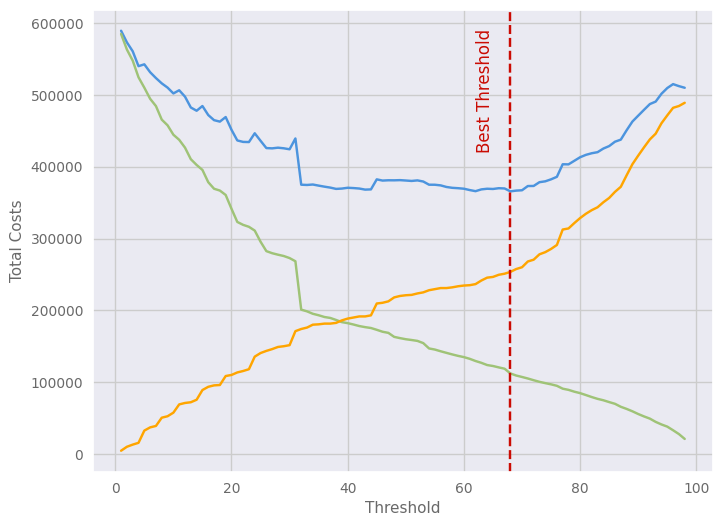

In [112]:
# Plot a scatterplot chart with each threshold point

point_x = df_cut_threshold.loc[df_cut_threshold['Threshold'] == best_threshold, 'Threshold'].values[0]
#point_y = df_cut_threshold.loc[df_cut_threshold['Threshold'] == best_threshold, 'Predictive Costs'].values[0]

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x= 'Threshold', y= 'Total Costs', data= df_cut_threshold, ax= ax)
sns.lineplot(x= 'Threshold', y= 'Regular Costs', data= df_cut_threshold, ax= ax, color= 'g')
sns.lineplot(x= 'Threshold', y= 'F Negative Costs (FN)', data= df_cut_threshold, ax= ax, color= 'orange')

ax.axvline(point_x, color= 'r', linestyle= '--')
ax.annotate('Best Threshold', xy=(point_x, 425000), color= 'r', xytext= (62, 425000), rotation= 90)

plt.show()

####Best Threshold Based on Minimum Total Expenses

  * If the business area finds that the best decision is search for the minimum total expenses, as seen on yellow line, the treshold of 68% (probability of belonging to class 1) is the best choice.

  * All prediction scores above 68% will be classified as Positive, including False Positives and True Positives, as seen on green line in the chart.

  * At 68% threshold the model will identify a few more False Negatives.

In [113]:
# Calculate best threshold for classification model using TP, TN, FP, FN and the charges associated to each category
# Using false negatives and false positives costa as preferred metrics

y_true = df_prev_selected['class']
y_pred_prob = best_xgboost.predict_proba(X)[:, 1] * 100
cost_fp = 10
cost_fn = 500
cost_tp = 25

# Define empty lists
threshold_list = []
# Lists for number of cases
TP_cases = []
FP_cases = []
FN_cases = []
TN_cases = []
# Lists for total costs
Total_costs = []
Regular_costs = []
FP_costs = []
TP_costs = []
FN_costs =[]


def calculate_best_threshold(y_true, y_pred_prob, cost_fp, cost_fn, cost_tp):

  best_threshold = 0
  min_cost = float('inf')

  for threshold in np.arange(1, 99, 1):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FN_cost = cost_fn * fn
    TP_cost = cost_tp * tp
    FP_cost = cost_fp * fp

    regular_cost = TP_cost + FP_cost
    cost = FN_cost + TP_cost + FP_cost

    #if cost < min_cost:
    if FN_cost < regular_cost < min_cost :
      min_cost = cost
      best_threshold = threshold

    # Store results
    TP_costs.append(TP_cost)
    FN_costs.append(FN_cost)
    FP_costs.append(FP_cost)
    Total_costs.append(cost)
    Regular_costs.append(regular_cost)
    TP_cases.append(tp)
    FP_cases.append(fp)
    FN_cases.append(fn)
    TN_cases.append(tn)
    threshold_list.append(threshold)

  return best_threshold

best_threshold = calculate_best_threshold(y_true, y_pred_prob, cost_fp, cost_fn, cost_tp)


print(f'Best Threshold: {best_threshold}')

df_cut_threshold = pd.DataFrame({'Threshold': threshold_list,
                                 'FP':FP_cases,
                                 'FN': FN_cases,
                                 'TP': TP_cases,
                                 'TN': TN_cases,
                                 'F Positive Costs (FP)': FP_costs,
                                 'F Negative Costs (FN)': FN_costs,
                                 'T Positive Costs (TP)': TP_costs,
                                 'Regular Costs': Regular_costs,
                                 'Total Costs': Total_costs
                                 })


Best Threshold: 38


In [123]:
display(df_cut_threshold.loc[(df_cut_threshold['Threshold'] >= best_threshold - 3) &
 (df_cut_threshold['Threshold'] <= best_threshold + 3)].style.apply(highlight_row, axis=1))

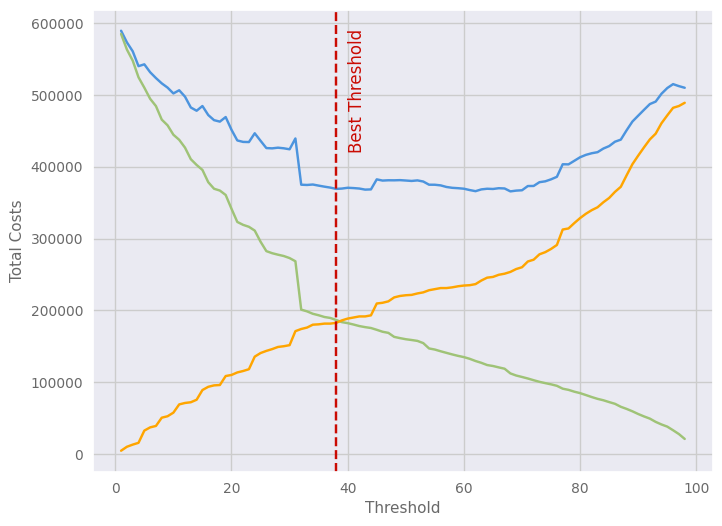

In [115]:
# Plot a scatterplot chart with each threshold point

point_x = df_cut_threshold.loc[df_cut_threshold['Threshold'] == best_threshold, 'Threshold'].values[0]
#point_y = df_cut_threshold.loc[df_cut_threshold['Threshold'] == best_threshold, 'Predictive Costs'].values[0]

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x= 'Threshold', y= 'Total Costs', data= df_cut_threshold, ax= ax)
sns.lineplot(x= 'Threshold', y= 'Regular Costs', data= df_cut_threshold, ax= ax, color= 'g')
sns.lineplot(x= 'Threshold', y= 'F Negative Costs (FN)', data= df_cut_threshold, ax= ax, color= 'orange')

ax.axvline(point_x, color= 'r', linestyle= '--')
ax.annotate('Best Threshold', xy=(point_x, 425000), color= 'r', xytext= (40, 425000), rotation= 90)

plt.show()

####Best Threshold Based on Minimum False Negatives Expenses

  * At 38% threshold, the model will optimize False Negatives expenses balanced with False Positive expenses.

  * There will be a slightly increase in total expenses, but this way is probably better for operational purposes, as it won't take off some of the trucks from the delivery services.

  * The best approach needs to be discussed with business team to make a collective decision based on data, but also on operational knowledge.

###Applying best model to current year dataset

In [124]:
# Export best XGBoost model to a pickle file to further use

import pickle

# Assuming 'best_xgboost' is your trained XGBoost model
filename = 'best_xgboost_model.pkl'
pickle.dump(best_xgboost, open(filename, 'wb'))


In [135]:
# Applying the choosen model to make predictions on current year dataset
# Apply the same preprocessing steps (imputation, scaling) to the new dataset

# Apply data cleaning functions
check_duplicates(df_curr)
replace_na(df_curr, 'na', np.nan)
encode_class (df_curr, 'class', 'neg', 'pos', 0, 1)

# Split train and test datasets using the dataset with selected features
df = df_curr[all_selected_cols].copy()

X = df.drop(columns= ['class'])
y = df['class']

x_train, x_test, y_train, y_test = train_test_split( X, y, test_size= 0.3, stratify = y, random_state= 71)

x_train, x_test = impute_median (x_train, x_test)
x_train, x_test = standard_scaler (x_train, x_test)



False    16000
Name: count, dtype: int64


#### Applying model at 50% (default) Threshold

In [173]:
# Use pickle file to make predictions on the new dataset

# Load the saved model from the pickle file
with open('best_xgboost_model.pkl', 'rb') as f:
    pickle_model = pickle.load(f)

# Make predictions using the loaded model at 50% threshold (default)
predictions = pickle_model.predict(X)

# Predict probabilities
predictions_prob = pickle_model.predict_proba(X)[:, 1]

# Use the predictions as needed
print(predictions)
print(predictions_prob)

[1 0 0 ... 0 0 1]
[0.9219545  0.00281347 0.05911778 ... 0.32719707 0.16036975 0.52898246]


In [178]:
# Access score predictions of classification model and store in a new column
df['score_prediction'] = predictions_prob

# Access class predictions and store in a new column
df['class_prediction50'] = predictions

df.sample(3)

dy_000     cs_006  cl_000  ea_000    aq_000   ag_008  ag_003  aa_000  \
4471      0.0   381708.0     0.0     0.0  286950.0  55444.0     0.0   37220   
10363  4890.0   974492.0     0.0     0.0  478584.0     62.0     0.0   29796   
13635     0.0  1186680.0     0.0     0.0  459264.0  14510.0     0.0   61488   

       cj_000     az_004  ...    bs_000  ba_009  dj_000  cg_000  ch_000  \
4471      0.0  1747798.0  ...   25820.0     2.0     0.0   120.0     0.0   
10363     0.0    46988.0  ...  132940.0     0.0     0.0     NaN     NaN   
13635     0.0  2401962.0  ...  187900.0     0.0     0.0     NaN     NaN   

         az_003  score_prediction  class_prediction  score_prediction50  \
4471   209148.0          0.199481                 0            0.199481   
10363    1580.0          0.475337                 0            0.475337   
13635   15578.0          0.555006                 1            0.555006   

       class_prediction50  
4471                    0  
10363                   0  
13635                   1  

[3 rows x 104 columns]

In [179]:
# Print value counts of the predicted class at default threshold

df['class_prediction50'].value_counts()

class_prediction50
0    11952
1     4048
Name: count, dtype: int64

In [176]:
# Print value counts of the predicted class on original dataset

df_curr['class'].value_counts()

class
0    15625
1      375
Name: count, dtype: int64

Confusion Matrix:
[[11790  3835]
 [  162   213]]


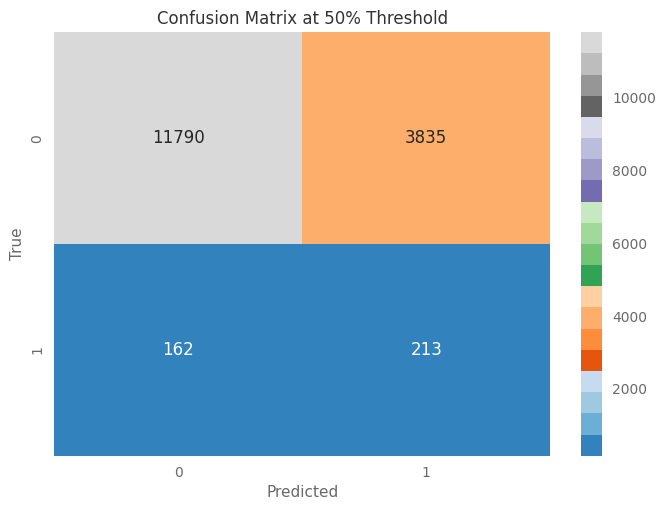

In [181]:
# Analyse confusion matrix at 50% threshold

cm50 = confusion_matrix(y, df['class_prediction'])

print("Confusion Matrix:")
print(cm50)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm50, annot=True, fmt='d', cmap= 'tab20c')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix at 50% Threshold')
plt.show()


####Applying Model at 68% Threshold

In [182]:
# Access score predictions of classification model and store in a new column in a choosen threshold
df['score_prediction'] = predictions_prob

# Access class predictions and store in a new column
df['class_prediction68'] = (df['score_prediction'] >= 0.68).astype(int)

df.sample(3)

dy_000     cs_006  cl_000  ea_000    aq_000    ag_008  ag_003  aa_000  \
11943    70.0     5496.0     NaN    10.0     724.0       0.0     0.0      54   
9574      0.0  1135362.0     2.0     0.0  206022.0  129916.0     0.0   41506   
300       0.0   687306.0    62.0     0.0  360108.0   23242.0     0.0   28966   

       cj_000    az_004  ...  ba_009  dj_000  cg_000  ch_000  az_003  \
11943     0.0    5744.0  ...    12.0     0.0     2.0     0.0   118.0   
9574      0.0  218298.0  ...     0.0     0.0   120.0     0.0  6776.0   
300       0.0  437358.0  ...    14.0     0.0     NaN     NaN  3578.0   

       score_prediction  class_prediction  score_prediction50  \
11943          0.011635                 0            0.011635   
9574           0.317046                 0            0.317046   
300            0.380179                 0            0.380179   

       class_prediction50  class_prediction68  
11943                   0                   0  
9574                    0                   0  
300                     0                   0  

[3 rows x 105 columns]

In [183]:
# Print value counts of the predicted class

df['class_prediction68'].value_counts()

class_prediction68
0    13210
1     2790
Name: count, dtype: int64

Confusion Matrix:
[[11790  3835]
 [  162   213]]


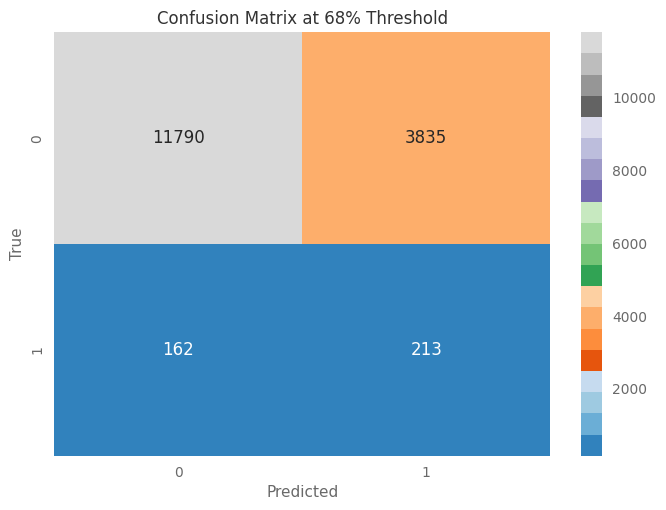

In [184]:
# Analyse confusion matrix at 68% threshold

cm68 = confusion_matrix(y, df['class_prediction'])

print("Confusion Matrix:")
print(cm68)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap= 'tab20c')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix at 68% Threshold')
plt.show()


####Applying Model at 38% Threshold

In [185]:
# Access score predictions of classification model and store in a new column in a choosen threshold
df['score_prediction'] = predictions_prob

# Access class predictions and store in a new column
df['class_prediction38'] = (df['score_prediction'] >= 0.38).astype(int)

df.sample(3)

dy_000    cs_006  cl_000  ea_000    aq_000   ag_008  ag_003  aa_000  \
6416   190.0  783882.0     0.0     0.0  513752.0  48600.0     0.0   76618   
8670   686.0       0.0     0.0     0.0  168788.0      0.0     0.0   44466   
5203     0.0  385412.0     0.0     0.0  333680.0   9070.0     0.0   29964   

      cj_000     az_004  ...  dj_000  cg_000  ch_000    az_003  \
6416    0.00  3801770.0  ...     0.0    76.0     0.0   90384.0   
8670   51.84        0.0  ...     0.0    12.0     0.0       0.0   
5203    0.00  1086750.0  ...     0.0    60.0     0.0  161418.0   

      score_prediction  class_prediction  score_prediction50  \
6416          0.317046                 0            0.317046   
8670          0.991247                 1            0.991247   
5203          0.125471                 0            0.125471   

      class_prediction50  class_prediction68  class_prediction38  
6416                   0                   0                   0  
8670                   1                   1                   1  
5203                   0                   0                   0  

[3 rows x 106 columns]

In [186]:
# Print value counts of the predicted class

df['class_prediction38'].value_counts()

class_prediction38
0    11301
1     4699
Name: count, dtype: int64

Confusion Matrix:
[[11790  3835]
 [  162   213]]


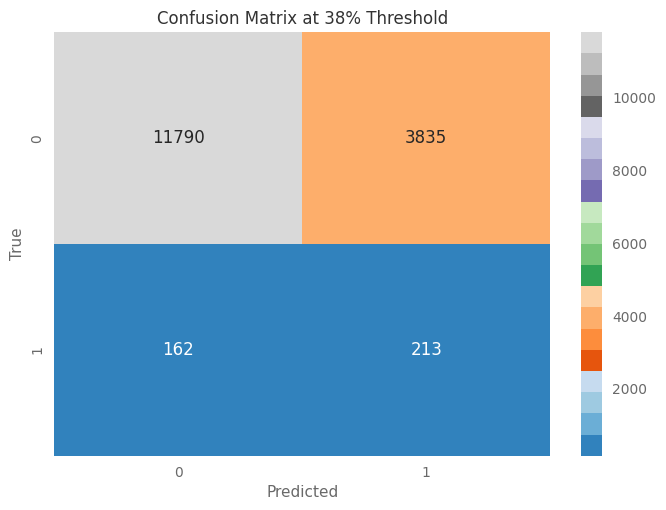

In [187]:
# Analyse confusion matrix at 38% threshold

cm38 = confusion_matrix(y, df['class_prediction'])

print("Confusion Matrix:")
print(cm38)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap= 'tab20c')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix at 38% Threshold')
plt.show()


In [189]:
# Make a comparative table of TP, FN, TN, FP for treshold 50%, 68% and 38%

# Calculate confusion matrices for each threshold
cm50 = confusion_matrix(y, df['class_prediction50'])
cm68 = confusion_matrix(y, df['class_prediction68'])
cm38 = confusion_matrix(y, df['class_prediction38'])

# Extract TP, FN, TN, FP for each threshold
tn50, fp50, fn50, tp50 = cm50.ravel()
tn68, fp68, fn68, tp68 = cm68.ravel()
tn38, fp38, fn38, tp38 = cm38.ravel()

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Threshold': [50, 68, 38],
    'TP': [tp50, tp68, tp38],
    'FN': [fn50, fn68, fn38],
    'TN': [tn50, tn68, tn38],
    'FP': [fp50, fp68, fp38]
})

# Display the results
display(results_df)


Threshold   TP   FN     TN    FP
0         50  213  162  11790  3835
1         68  179  196  13014  2611
2         38  240  135  11166  4459

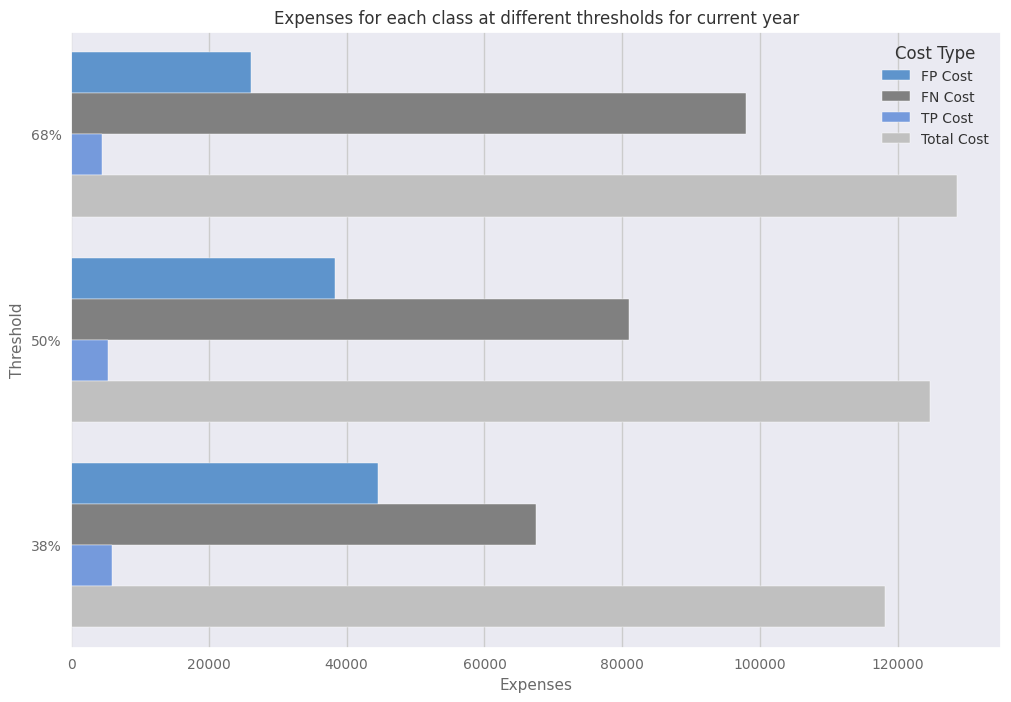

In [194]:
# prompt: plot a sns horizontal bar chart with expenses for each class at 50%, 68% and 38%  threshold and total expenses based on each class costs

# Calculate costs for each threshold and class
cost_fp = 10
cost_fn = 500
cost_tp = 25

def calculate_costs(cm, cost_fp, cost_fn, cost_tp):
  tn, fp, fn, tp = cm.ravel()
  fp_cost = fp * cost_fp
  fn_cost = fn * cost_fn
  tp_cost = tp * cost_tp
  total_cost = fp_cost + fn_cost + tp_cost
  return fp_cost, fn_cost, tp_cost, total_cost

fp_cost68, fn_cost68, tp_cost68, total_cost68 = calculate_costs(cm68, cost_fp, cost_fn, cost_tp)
fp_cost50, fn_cost50, tp_cost50, total_cost50 = calculate_costs(cm50, cost_fp, cost_fn, cost_tp)
fp_cost38, fn_cost38, tp_cost38, total_cost38 = calculate_costs(cm38, cost_fp, cost_fn, cost_tp)

# Create a DataFrame for the bar chart
cost_df = pd.DataFrame({
    'Threshold': ['68%', '50%', '38%'],
    'FP Cost': [fp_cost68, fp_cost50, fp_cost38],
    'FN Cost': [fn_cost68, fn_cost50, fn_cost38],
    'TP Cost': [tp_cost68, tp_cost50, tp_cost38],
    'Total Cost': [total_cost68, total_cost50, total_cost38]
})

# Melt the DataFrame for plotting
cost_df_melted = cost_df.melt(id_vars='Threshold', var_name='Cost Type', value_name='Cost')

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Cost', y='Threshold', hue='Cost Type', data=cost_df_melted)
plt.xlabel('Expenses')
plt.ylabel('Threshold')
plt.title('Expenses for each class at different thresholds for current year')
plt.legend(title='Cost Type')
plt.show()


####Conclusions

  * Some observations can be made about the above chart:

  1 - If the main objective is reducing total costs, a model with 38% threshold it's probably the best choice based on this years data.
  
  2 - But at this low limit, there will be a few more False Positive cases, that are not so expensive, but has the bad effect of reducing the circulating trucks fleet. False positives force trucks that are not defective, but are misclassified, to stop.

  3 - At this limit, all costs are lower, except False Positive costs. Total costs are less than other thresholds as well as the rate of False Negatives.

